In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from omegaconf import OmegaConf
import hydra
from trainRNNbrain.analyzers.PerformanceAnalyzer import PerformanceAnalyzer
from trainRNNbrain.utils import jsonify, unjsonify
from trainRNNbrain.training.training_utils import prepare_task_arguments, get_training_mask
from trainRNNbrain.rnns.RNN_numpy import RNN_numpy
np.set_printoptions(suppress=True)
import mplcursors
from trainRNNbrain.training.training_utils import *

In [74]:
data_folder = '/Users/tolmach/Documents/GitHub/trainRNNbrain/data/trained_RNNs/CDDM_LogSumExpTau01LambdaSM_abSweepAdditivePenalty-dc053e2_BaseTrainer/0.86822_CDDM_relu;N=1000;L=0.001;MI=20000;D=0;WD=1e-06;Lcl=0;Lhi=0;Lhlvar=0;Lhtvar=0;Liwm=0;Lmet=0;Lorth=0.3;Low=0;Lrwm=0;Lrws=0.05;Lsi=0;Lsm=0.2;Ltv=0'


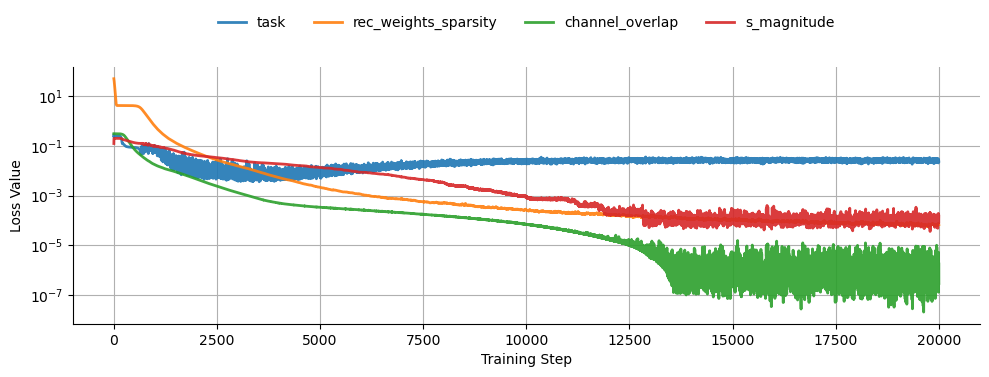

In [76]:
# %matplotlib widget
score = data_folder.split("/")[-1].split("_")[0]
try:
    with open(os.path.join(data_folder,f"{score}_LossBreakdown.json"), 'rb+') as f:
        loss_monitor = json.load(f)
    t = -1
    
    fig_loss_breakdown, ax = plt.subplots(figsize=(10, 4))
    ax.set_yscale('log')
    for key in loss_monitor:
        if np.std(loss_monitor[key]) != 0:
            ax.plot(np.array(loss_monitor[key]), label=key, alpha=0.9, linewidth = 2.)
    # ax.set_ylim([0, 1])
    ax.set_xlabel("Training Step")
    ax.set_ylabel("Loss Value")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=5, frameon=False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_ylim([2e-3, 0.1])
    ax.grid(True)
    plt.tight_layout()
except:
    print("no loss file")

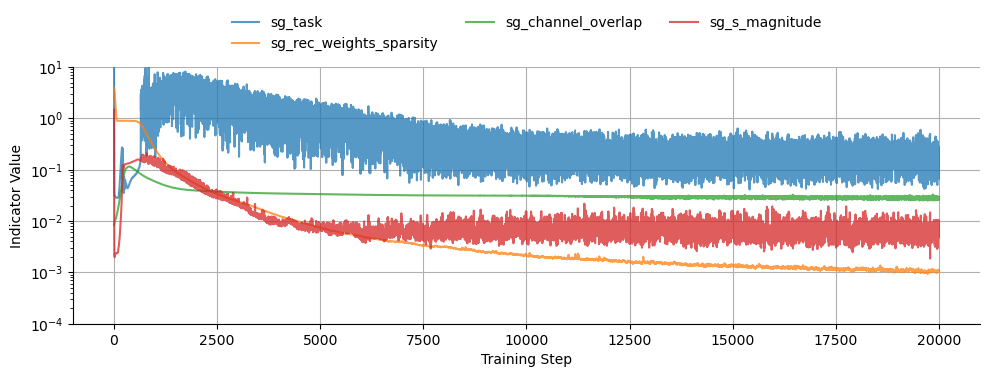

In [77]:
# %matplotlib widget
score = data_folder.split("/")[-1].split("_")[0]
try:
    with open(os.path.join(data_folder,f"{score}_GradsScaled.json"), 'rb+') as f:
        loss_monitor = json.load(f)
    t = -1
    
    fig_loss_breakdown, ax = plt.subplots(figsize=(10, 4))
    ax.set_yscale('log')
    for key in loss_monitor:
        if key == 'gini participation':
            continue
        if np.std(loss_monitor[key]) != 0:
            ax.plot(loss_monitor[key], label=key, alpha=0.75, linewidth = 1.5)
    # ax.set_ylim([0, 1])
    ax.set_xlabel("Training Step")
    ax.set_ylabel("Indicator Value")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=3, frameon=False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylim([1e-4, 10])
    ax.grid(True)
    plt.tight_layout()
except:
    print("no monitor files")

In [78]:
score = data_folder.split("/")[-1].split("_")[0]
cfg = OmegaConf.load(os.path.join(data_folder, f'{score}_config.yaml'))

In [79]:
if not OmegaConf.has_resolver("eval"):
    OmegaConf.register_new_resolver("eval", eval)
taskname = cfg.task.taskname
tag = f"relu_constrained=constrained"
print(f"training {taskname}, {tag}")

# defining the task
task_conf = prepare_task_arguments(cfg_task=cfg.task, dt=cfg.model.dt)
task = hydra.utils.instantiate(task_conf)

training CDDM, relu_constrained=constrained


In [80]:
cfg.trainer

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 20000, 'anneal_noise': True, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.3, 'orth_args': {'orth_input_only': True}, 'lambda_iwm': 0, 'iwm_args': {'cap100': 0.5, 'gamma': 5.0, 'eps': 1e-12}, 'lambda_rwm': 0.0, 'rwm_args': {'cap100': 0.07, 'N_ref': 100, 'k_ref': 20, 'gamma': 5.0, 'eps': 1e-12}, 'lambda_ow': 0, 'ow_args': {'c': 2.0, 'cap100': 0.3, 'alpha': 1.0, 'gamma': 5.0, 'eps': 1e-12}, 'lambda_met': 0, 'met_args': {}, 'lambda_rws': 0.05, 'rws_args': {'tg_deg': 20, 'eps': 1e-12}, 'lambda_sm': 0.2, 'sm_args': {'cap_s': 0.3, 'quantile_kind': 'logsumexp', 'p': 15, 'q': 0.9, 'tau': 0.1, 'penalty_type': 'additive', 'g_top': 3.0, 'g_bot': 3.0, 'alpha': 1, 'beta': 1, 'eps': 1e-12}, 'lambda_tv': 0, 'tv_args': {}, 'lambda_si': 0, 'si_args': {'method': 'hhi'}, 'lambda_hi': 0, 'hi_args': {'method': 

In [81]:
import inspect
def filter_kwargs(callable_obj, params: dict):
    sig = inspect.signature(callable_obj)
    # if it accepts **kwargs, pass everything through
    if any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
        return params
    allowed = {name for name, p in sig.parameters.items()
               if name != 'self' and p.kind in (p.POSITIONAL_OR_KEYWORD, p.KEYWORD_ONLY)}
    return {k: v for k, v in params.items() if k in allowed}

net_params_file = f"{score}_LastParams_CDDM.json"
print(data_folder, net_params_file)
with open(os.path.join(data_folder, net_params_file), 'r') as f:
    net_params = unjsonify(json.load(f))
# positions = np.array(net_params["positions"])
# dale_mask = np.array(net_params["dale_mask"])
# recurrent_mask = np.array(net_params["recurrent_mask"])
print(net_params.keys())
mask = get_training_mask(cfg_task=cfg.task, dt=cfg.model.dt)
net_params_filtered = filter_kwargs(RNN_numpy, net_params)
RNN = RNN_numpy(**net_params_filtered)

/Users/tolmach/Documents/GitHub/trainRNNbrain/data/trained_RNNs/CDDM_LogSumExpTau01LambdaSM_abSweepAdditivePenalty-dc053e2_BaseTrainer/0.86822_CDDM_relu;N=1000;L=0.001;MI=20000;D=0;WD=1e-06;Lcl=0;Lhi=0;Lhlvar=0;Lhtvar=0;Liwm=0;Lmet=0;Lorth=0.3;Low=0;Lrwm=0;Lrws=0.05;Lsi=0;Lsm=0.2;Ltv=0 0.86822_LastParams_CDDM.json
dict_keys(['activation_name', 'activation_slope', 'W_out', 'W_inp', 'W_rec', 'y_init', 'bias', 'N', 'dt', 'tau', 'gamma', 'dale_mask', 'input_mask', 'recurrent_mask', 'output_mask'])


In [82]:
analyzer = PerformanceAnalyzer(RNN)
score_function = lambda x, y: 1 - (np.mean((x - y) ** 2) / np.mean(y ** 2))
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
sigma_rec = cfg.model.sigma_rec
sigma_inp = cfg.model.sigma_inp
score = analyzer.get_validation_score(score_function,
                                      input_batch_valid, target_batch_valid,
                                      mask,
                                      sigma_rec=sigma_rec, 
                                      sigma_inp=sigma_inp,
                                      seed=42)
score = np.round(score, 7)
print(f"r2 validation: {score}")

r2 validation: 0.8818772


In [83]:
task.coherences = np.array([-0.5, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.5])
input_batch, target_batch, conditions = task.get_batch()
# trajectories, outputs = analyzer.get_trajectories(input_batch, ) # get sorted trajectories
analyzer.RNN.clear_history()
analyzer.RNN.y = analyzer.RNN.y_init
analyzer.RNN.run(input_timeseries=input_batch, sigma_rec=0.00, sigma_inp=0.00)
trajectories = analyzer.RNN.get_history()
outputs = analyzer.RNN.get_output()


W_rec = np.array(net_params["W_rec"])
W_inp = np.array(net_params["W_inp"])
W_out = np.array(net_params["W_out"])
dale_mask = np.sign(np.sum(W_rec, axis = 0))
h = np.einsum('ij,jtk->itk',W_rec, trajectories) + np.einsum('ij,jtk->itk', W_inp, input_batch)

In [84]:
# # prerequisites (in a notebook cell, once)
# import numpy as np, matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from sklearn.decomposition import PCA
# from IPython.display import HTML
# plt.rcParams["animation.html"] = "jshtml"  # make ani._repr_html_() show in outputs

# def animate_selectivity(trajectories, axes=(0,1,2), labels=None, fps=30):
#     F = trajectories.reshape(trajectories.shape[0], -1)
#     P = PCA(n_components=min(10, F.shape[1])).fit(F).components_
#     S = F @ P.T

#     fig = plt.figure()
#     ax  = fig.add_subplot(111, projection='3d')
#     for axis in (ax.xaxis, ax.yaxis, ax.zaxis): axis.set_pane_color((1,1,1,0))

#     if labels is not None:
#         labels = np.asarray(labels)
#         uniq = np.unique(labels)
#         palette = np.array(['#D62728','#1F77B4','#2CA02C','#9467BD','#FF7F0E','#17BECF'])
#         colmap = {u: palette[i % len(palette)] for i,u in enumerate(uniq)}
#         point_colors = np.vectorize(colmap.get)(labels)
#     else:
#         point_colors = np.full(S.shape[0], '#D62728')

#     scatter = ax.scatter(S[:,axes[0]], S[:,axes[1]], S[:,axes[2]],
#                          c=point_colors, marker='o', s=40, edgecolor='k', linewidths=0.25)

#     # minimalist ticks
#     ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
#     ax.set_xlabel('PC{}'.format(axes[0]+1)); ax.set_ylabel('PC{}'.format(axes[1]+1)); ax.set_zlabel('PC{}'.format(axes[2]+1))

#     def update(frame):
#         ax.view_init(elev=15 + frame/12, azim=frame)
#         return scatter,

#     ani = FuncAnimation(fig, update, frames=np.arange(0, 720, 2), interval=1000/fps, blit=False)
#     plt.close(fig)                     # prevent duplicate static figure
#     return HTML(ani.to_jshtml())       # display(animate_selectivity(...)) will show inline

# display(animate_selectivity(trajectories, axes=(0,1,2), labels=None))

In [85]:
# import numpy as np, torch, matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from mpl_toolkits.mplot3d import proj3d
# from matplotlib.patches import FancyArrowPatch
# from IPython.display import HTML, display  # ← needed for to_jshtml()

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *a, **kw):
#         super().__init__((0, 0), (0, 0), *a, **kw)
#         self._verts3d = xs, ys, zs

#     def draw(self, renderer):
#         xs3d, ys3d, zs3d = self._verts3d
#         # use axes projection (works on modern Matplotlib)
#         proj = self.axes.get_proj()
#         xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, proj)
#         self.set_positions((xs[0], ys[0]), (xs[-1], ys[-1]))
#         super().draw(renderer)

#     def do_3d_projection(self, renderer=None):
#         # called for z-sorting
#         xs3d, ys3d, zs3d = self._verts3d
#         proj = self.axes.get_proj()
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, proj)
#         # also update 2D positions so the arrow head is placed correctly
#         self.set_positions((xs[0], ys[0]), (xs[-1], ys[-1]))
#         return float(np.min(zs))

# def visualize_connectivity_3d(W_rec, W_inp, W_out, recurrent_mask, dale_mask, output_mask, input_mask,
#                               pos, d=1.0, max_edges=4000, point_size=18, line_alpha=0.08, bend=0.12, fps=30):
#     to_np = lambda t: (t.detach().cpu().numpy() if hasattr(t, "detach") else np.asarray(t))
#     P = to_np(pos); z, x, y = P[:,0], P[:,1], P[:,2]
#     side = np.sqrt(float(recurrent_mask.shape[0]) / 100.0)

#     W = to_np(W_rec)  # W[post, pre]
#     M = to_np(recurrent_mask).astype(bool)
#     ii, jj = np.where(M); 
#     if ii.size > max_edges:
#         sel = np.random.choice(ii.size, max_edges, replace=False); ii, jj = ii[sel], jj[sel]

#     w_vals = np.abs(W[ii, jj]); w_max = w_vals.max() if w_vals.size else 1.0
#     cols = np.where(W[ii, jj] > 0, 'r', 'b')

#     Dmask = to_np(dale_mask); Dmask = Dmask.reshape(-1) if Dmask.ndim==1 and Dmask.shape[0]==P.shape[0] else np.sign(to_np(W).sum(0))
#     Dmask[Dmask==0] = 1.0; node_cols = np.where(Dmask > 0, 'r', 'b')

#     fig = plt.figure(figsize=(7,6)); ax = fig.add_subplot(111, projection='3d')
#     for a in (ax.xaxis, ax.yaxis, ax.zaxis): a.set_pane_color((1,1,1,0))
#     ax.set(xlim=(0,side), ylim=(0,side), zlim=(0,d)); ax.set_xticks([0,side]); ax.set_yticks([0,side]); ax.set_zticks([0,d])
#     ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])

#     def slab(z0,z1,color,alpha=0.03):
#         v=np.array([[0,0,z0],[side,0,z0],[side,side,z0],[0,side,z0],[0,0,z1],[side,0,z1],[side,side,z1],[0,side,z1]])
#         faces=[[v[i] for i in f] for f in ([0,1,2,3],[4,5,6,7],[0,1,5,4],[1,2,6,5],[2,3,7,6],[3,0,4,7])]
#         ax.add_collection3d(Poly3DCollection(faces, facecolors=(*color,alpha), edgecolors='none'))
#     def plane(zp,color=(0.2,0.2,0.2),alpha=0.05):
#         v=np.array([[0,0,zp],[side,0,zp],[side,side,zp],[0,side,zp]])
#         ax.add_collection3d(Poly3DCollection([v], facecolors=(*color,alpha), edgecolors='none'))

#     slab(0.00,0.25,(1,0,0)); slab(0.75,1.00,(0,0.8,0)); plane(0.25,(1,0,0)); plane(0.75,(0,0.8,0))
#     ax.scatter(x, y, z, c=node_cols, s=point_size, edgecolors='k', linewidths=0.25)

#     def bezier_quad(p0,p1,h=0.12,steps=32):
#         v=p1-p0; u=np.cross(v, np.array([0,0,1.0])); 
#         if np.linalg.norm(u)<1e-8: u=np.cross(v, np.array([0,1.0,0]))
#         u=u/(np.linalg.norm(u)+1e-12); mid=0.5*(p0+p1); c=mid+h*u*np.linalg.norm(v)
#         t=np.linspace(0,1,steps).reshape(-1,1); return ((1-t)**2)*p0 + 2*(1-t)*t*c + (t**2)*p1

#     for k in range(ii.size):
#         pre, post = jj[k], ii[k]
#         p0 = np.array([x[pre], y[pre], z[pre]]); p1 = np.array([x[post], y[post], z[post]])
#         pts = bezier_quad(p0, p1, h=bend, steps=32)
#         a = max(1e-3, float(w_vals[k] / (w_max + 1e-12)))  # alpha in (0,1], =1 for max
#         ax.plot(pts[:,0], pts[:,1], pts[:,2], color=cols[k], alpha=a*line_alpha, lw=1.0)
#         # arrowhead on last segment
#         p_head0, p_head1 = pts[-3], pts[-1]
#         arr = Arrow3D([p_head0[0],p_head1[0]], [p_head0[1],p_head1[1]], [p_head0[2],p_head1[2]],
#                       mutation_scale=8, lw=0.0, arrowstyle='-|>', color=cols[k], alpha=a)
#         ax.add_artist(arr)

#     def update(f): ax.view_init(elev=15+0.1*f, azim=f); return []
#     ani = FuncAnimation(fig, update, frames=np.arange(0,720,2), interval=1000/fps, blit=False)
#     return HTML(ani.to_jshtml())

In [86]:

# N = W_rec.shape[0]
# side_len = np.sqrt(N / float(100))
# pos = np.random.rand(N, 3)
# pos[:, 1:] *= side_len
# recurrent_mask = (W_rec != 0).astype(float)
# output_mask = (W_out != 0).astype(float)
# input_mask = (W_inp != 0).astype(float)
# display(visualize_connectivity_3d(W_rec, W_inp, W_out, recurrent_mask, dale_mask, output_mask, input_mask,
#                               pos, d=1.0, max_edges=400, point_size=18, line_alpha=0.8, bend=0.12, fps=15))


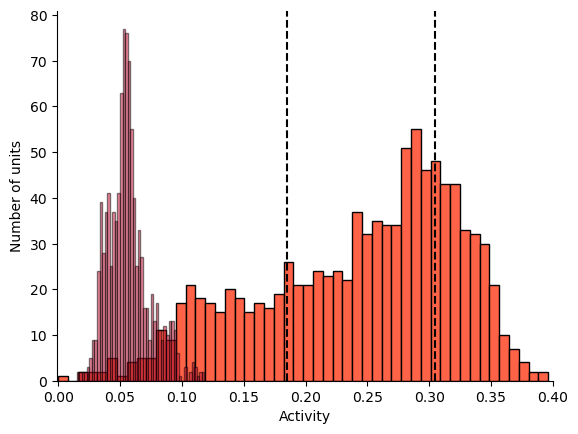

In [87]:
activity_m = np.mean(trajectories, axis = (1, 2))
activity_q = np.quantile(trajectories, axis = (1, 2), q=0.9)

fig, ax = plt.subplots()  # Create figure and axes
ax.hist(activity_q, bins=50, edgecolor='black', color = 'tomato', alpha =1.0)  # Plot histogram on the axes
ax.hist(activity_m, bins=50, edgecolor='black', color = 'crimson', alpha =0.5)  # Plot histogram on the axes
ax.axvline(np.quantile(activity_q, 0.25), linestyle='--', color = 'k')
ax.axvline(np.quantile(activity_q, 0.75), linestyle='--', color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Activity")
ax.set_ylabel("Number of units")
ax.set_xlim([-0.001, 1.01 * max(activity_q)])
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

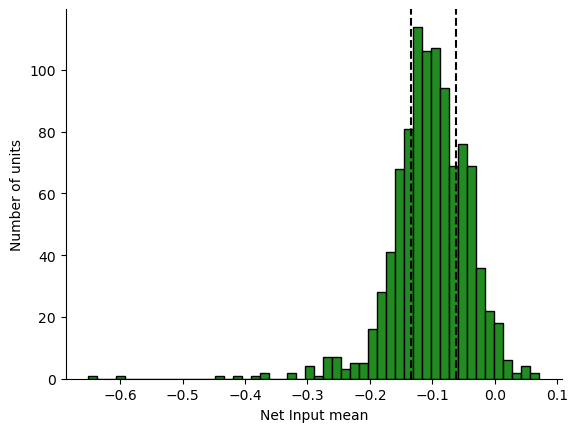

In [88]:
net_input_mean = np.mean(h, axis = (1, 2))

fig, ax = plt.subplots()  # Create figure and axes
ax.hist(net_input_mean, bins=50, edgecolor='black', color = 'forestgreen')  
ax.axvline(np.quantile(net_input_mean, 0.25), linestyle='--', color = 'k')
ax.axvline(np.quantile(net_input_mean, 0.75), linestyle='--', color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Net Input mean")
ax.set_ylabel("Number of units")
# ax.set_xlim([-0.001, 1.01 * max(net_input_mean)])
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

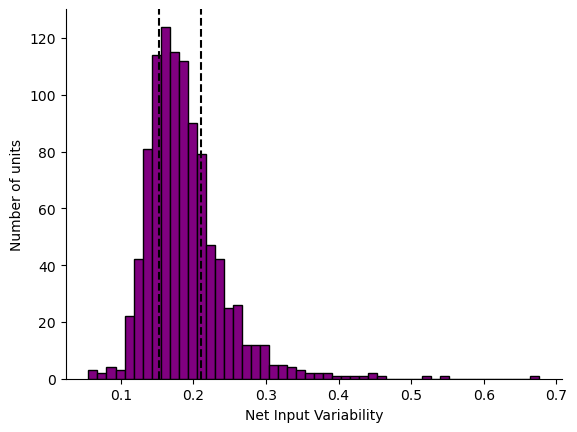

In [89]:
net_input_variability = np.mean(np.std(h, axis = -1), axis = -1)


fig, ax = plt.subplots()  # Create figure and axes
ax.hist(net_input_variability, bins=50, edgecolor='black', color = 'purple')  # Plot histogram on the axes
ax.axvline(np.quantile(net_input_variability, 0.25), linestyle='--', color = 'k')
ax.axvline(np.quantile(net_input_variability, 0.75), linestyle='--', color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Net Input Variability")
ax.set_ylabel("Number of units")
# ax.set_xlim([-0.001, 1.01 * max(net_input_variability)])
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

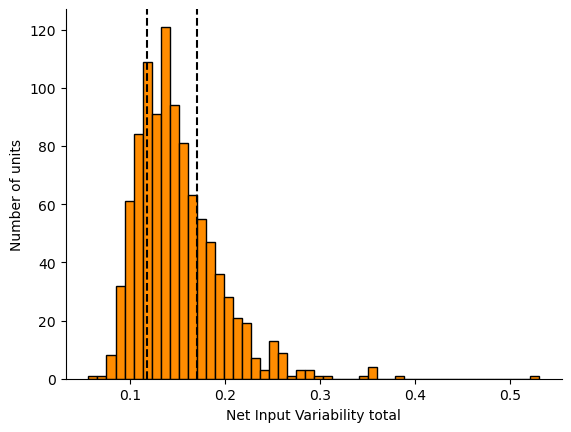

In [90]:
net_input_variability_t = np.mean(np.std(h, axis = 1), axis =-1)

fig, ax = plt.subplots()  # Create figure and axes
ax.hist(net_input_variability_t, bins=50, edgecolor='black', color = 'darkorange')  # Plot histogram on the axes
ax.axvline(np.quantile(net_input_variability_t, 0.25), linestyle='--', color = 'k')
ax.axvline(np.quantile(net_input_variability_t, 0.75), linestyle='--', color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Net Input Variability total")
ax.set_ylabel("Number of units")
# ax.set_xlim([-0.001, 1.01 * max(net_input_variability)])
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

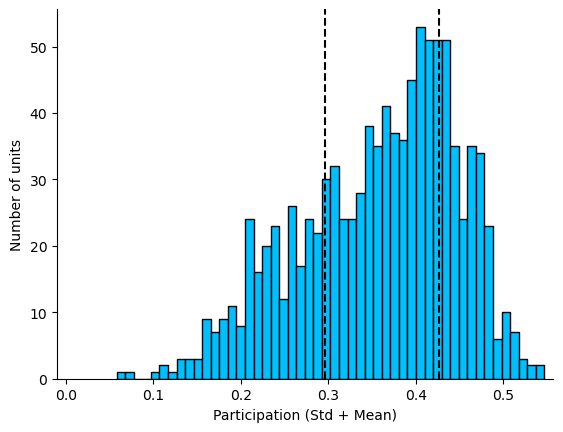

In [91]:
participation = np.std(trajectories, axis = (1, 2)) + np.quantile(np.abs(trajectories), axis = (1, 2), q=0.9)

fig, ax = plt.subplots()  # Create figure and axes
ax.hist(participation, bins=50, edgecolor='black', color = 'deepskyblue')  # Plot histogram on the axes
ax.axvline(np.quantile(participation, 0.25), linestyle='--', color = 'k')
ax.axvline(np.quantile(participation, 0.75), linestyle='--', color = 'k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Participation (Std + Mean)")
ax.set_ylabel("Number of units")
ax.set_xlim([-0.01, max(participation)+0.01])
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

In [98]:
m1 = np.max((W_out > 1e-6).astype(float), axis = 0)
m2 = np.max((W_inp > 1e-6).astype(float), axis = 1)
print(np.sum(m1 * m2))

532.0


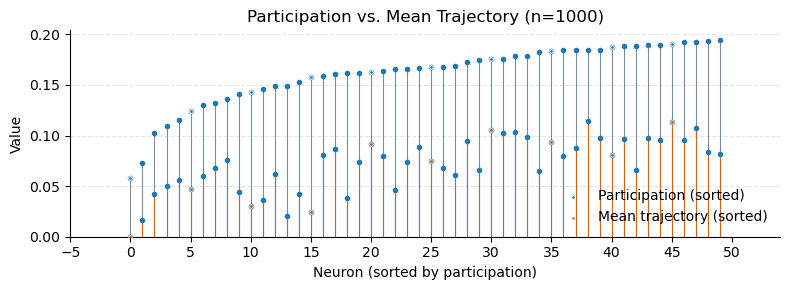

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

L = 50
participation = np.std(trajectories, axis = (1, 2)) + np.quantile(np.abs(trajectories), axis = (1, 2), q=0.9)
order = np.argsort(participation)                        # sort index by participation
participation_sorted = participation[order][:L]                              # sorted participation
traj_mean = np.quantile(trajectories, axis=(1, 2), q=0.9)
traj_mean_sorted = traj_mean[order][:L] # align to the same sort

N = len(participation)
x = np.arange(N)[:L]

fig, ax = plt.subplots(figsize=(8, 3))

# --- Stem 1: participation (blue/grey stems), no default markers
m1, s1, b1 = ax.stem(x, participation_sorted, basefmt=" ")
m1.set_markersize(3)
plt.setp(s1, linewidth=0.8, color="#6a7f99", alpha=0.9)
# markers every k-th stem (smaller size)
k = 5
ax.scatter(
    x[::k], participation_sorted[::k],
    s=7,                           # smaller markers
    facecolors="#1f77b4",
    edgecolors="white",
    linewidths=0.7,
    zorder=3,
    label="Participation (sorted)"
)

# --- Stem 2: mean trajectory (orange stems), aligned to same order
m2, s2, b2 = ax.stem(x, traj_mean_sorted, basefmt=" ")
m2.set_markersize(3)
plt.setp(s2, linewidth=0.8, color="#d95f02", alpha=0.8)
ax.scatter(
    x[::k], traj_mean_sorted[::k],
    s=7,                           # same reduced size
    facecolors="#d95f02",
    edgecolors="white",
    linewidths=0.7,
    zorder=3,
    alpha=0.75,
    label="Mean trajectory (sorted)"
)

# Styling
ax.set_title(f"Participation vs. Mean Trajectory (n={N})")
ax.set_xlabel("Neuron (sorted by participation)")
ax.set_ylabel("Value")
ax.grid(True, axis="y", linestyle="--", alpha=0.3)
ax.set_xlim(-5, len(x) - 1 + 5)
ax.set_ylim(0, 1.05 * max(participation_sorted.max(), participation_sorted.max()))
ax.xaxis.set_major_locator(MaxNLocator(nbins=12, integer=True))

# Remove right/top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.legend(frameon=False)
plt.tight_layout()
plt.show()


In [100]:
X = trajectories.reshape(trajectories.shape[0], trajectories.shape[1] * trajectories.shape[2])

_, S, _ = np.linalg.svd(X, full_matrices=False)

0.9528141134289407


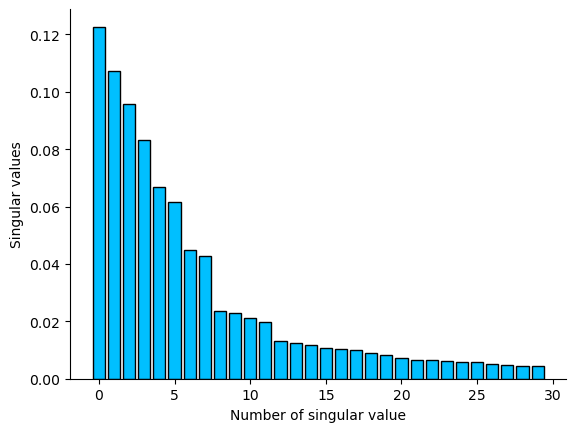

In [101]:
eps = 1e-8
S_norm = S / (S.sum() + eps)
# Flip to ascending order for proper Gini computation
S_sorted = S_norm[::-1]
# Gini index formula
n = S_sorted.size
index = np.arange(1, n + 1)
gini = (2 * (index * S_sorted).sum() / (n * S_sorted.sum() + eps)) - (n + 1) / n
print(gini)


k = 30
fig, ax = plt.subplots()  # Create figure and axes
ax.bar(np.arange(len(S_norm))[:k], S_norm[:k], edgecolor='black', color = 'deepskyblue')  # Plot histogram on the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Singular values")
ax.set_xlabel("Number of singular value")
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

In [102]:
# Extract condition metadata
contexts = [cond["context"] for cond in conditions]
motion_cohs = np.array([cond["motion_coh"] for cond in conditions])
color_cohs = np.array([cond["color_coh"] for cond in conditions])
marker_map = {'motion': 'o', 'color': 's'}

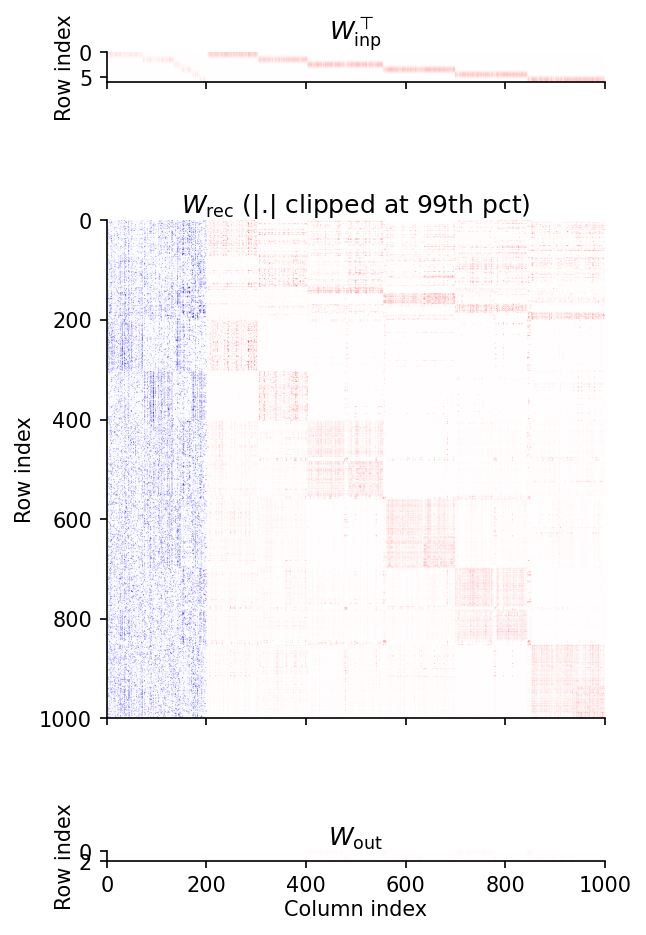

In [103]:
dale_mask_bool = ((np.sign(np.sum(RNN.W_rec, axis = 0)) + 1) / 2).astype(bool)
dale_mask_int = (np.sign(np.sum(RNN.W_rec, axis=0)) + 1).astype(int)
perm = analyzer.composite_lexicographic_sort(RNN.W_inp, RNN.W_out.T, dale_mask_int)
W_inp_, W_rec_, W_out_, dale_mask_bool_ = analyzer.permute_matrices(RNN.W_inp,
                                                               RNN.W_rec,
                                                               RNN.W_out,
                                                               dale_mask_bool, perm)
analyzer.RNN.W_inp = W_inp_
analyzer.RNN.W_rec = W_rec_
analyzer.RNN.W_out = W_out_
analyzer.RNN.dale_mask = dale_mask_bool_
fig_matrices = analyzer.plot_matrices()
plt.show()

In [104]:
def stem_plot(data):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    stem_container = ax.stem(data, basefmt=" ")
    
    # Unpack the stem elements
    markerline, stemlines, baseline = stem_container
    
    # Control marker (the dots at the top)
    markerline.set_marker('o')        # Marker style: 'o', 's', '^', etc.
    markerline.set_markerfacecolor('red')
    markerline.set_markeredgecolor('k')
    markerline.set_markersize(3)
    
    # Control the stems (vertical lines)
    stemlines.set_color('blue')
    stemlines.set_linewidth(2)
    
    # Control the baseline (horizontal line at zero)
    baseline.set_color('gray')
    baseline.set_linewidth(1)
    
    # Clean up look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

mean activity of neurons


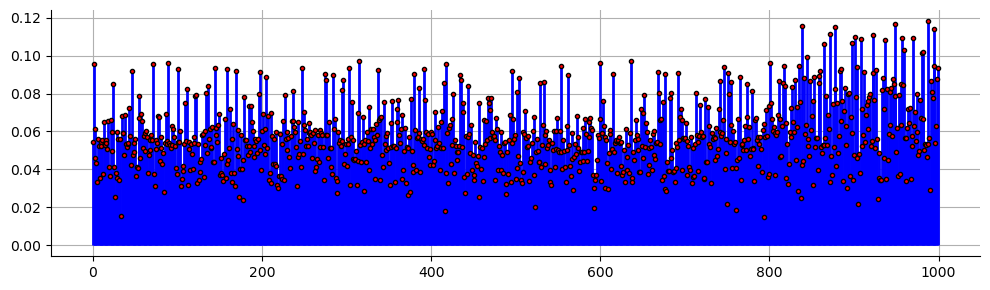

participation: mean + std


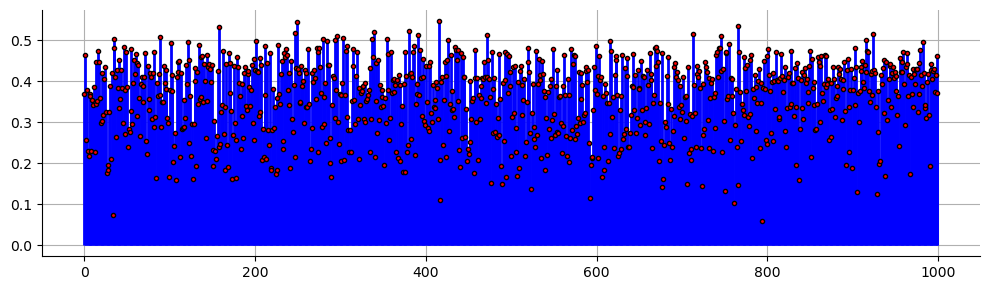

In [105]:
print("mean activity of neurons")
data = np.mean(np.abs(trajectories), axis=(1,2))
stem_plot(data)

print("participation: mean + std")
stem_plot(participation)

trajectory mean over trials
Trial activity
Net inputs activity
sending


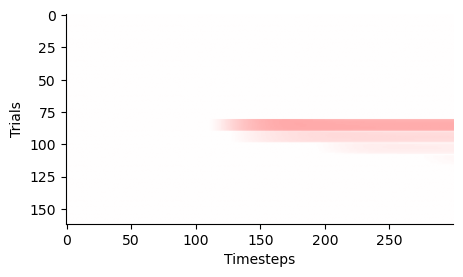

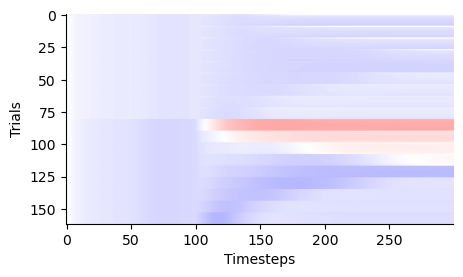

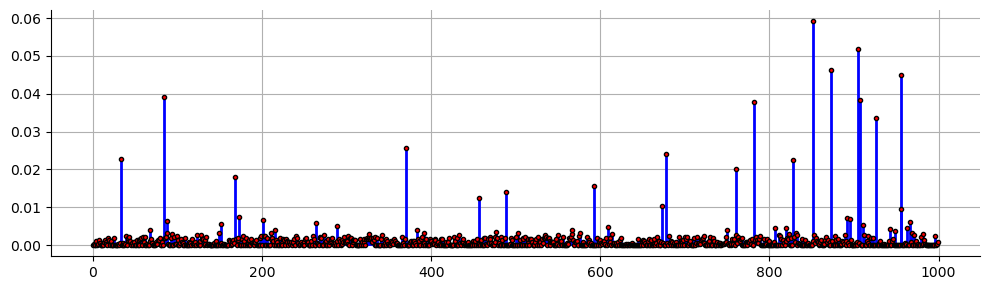

receiving


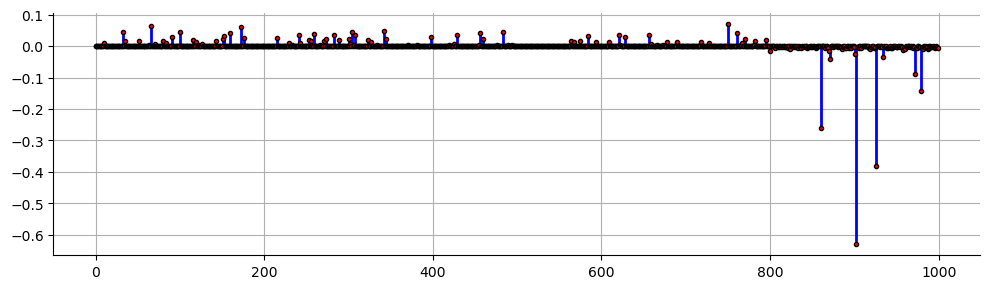

Excitation to inhibition ratio
0.8208036203469359
Excitation strength
6.481008141050227e-05
Inhibition strength
0.0032144664615384173


In [106]:
i = np.argmin(participation)

print("trajectory mean over trials")
print("Trial activity")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(trajectories[i, :, :].T, cmap='bwr', vmin = -1, vmax=1) # mean over trials
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Trials")
ax.set_xlabel("Timesteps")

print("Net inputs activity")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(h[i, :, :].T, cmap='bwr', vmin = -1, vmax=1) # mean over trials
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Trials")
ax.set_xlabel("Timesteps")

print("sending")
stem_plot(W_rec[:, i]) # sending
print("receiving")
stem_plot(W_rec[i, :]) # sending

print("Excitation to inhibition ratio")
print(- np.sum(W_rec[i, np.where(dale_mask == 1)[0]]) / np.sum(W_rec[i, np.where(dale_mask == -1)[0]]))

print("Excitation strength")
print(np.mean(W_rec[i, np.where(dale_mask == 1)[0]]**2))

print("Inhibition strength")
print(np.mean(W_rec[i, np.where(dale_mask == -1)[0]]**2))

# in comparison, the most active neuron

Trial activity


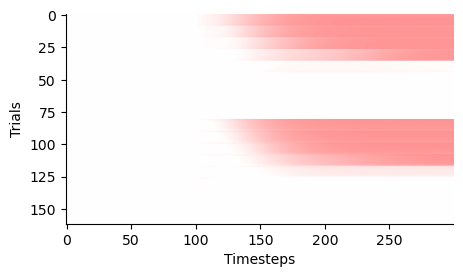

Net inputs activity


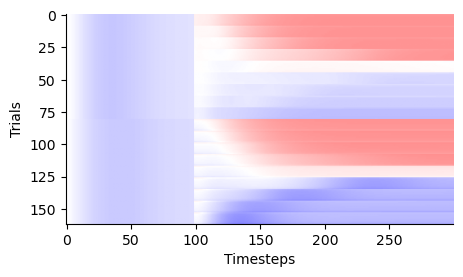

sending


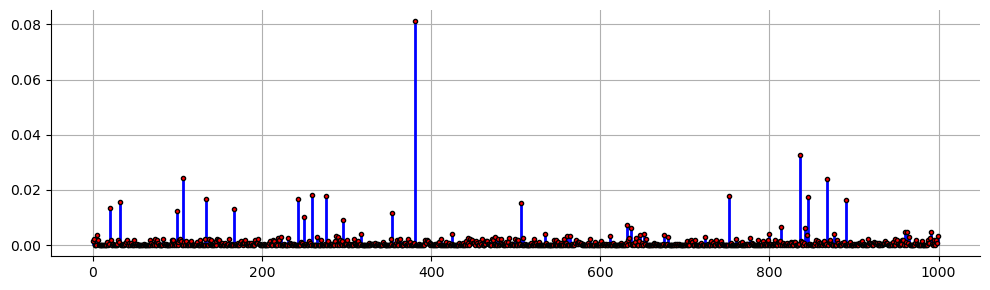

receiving


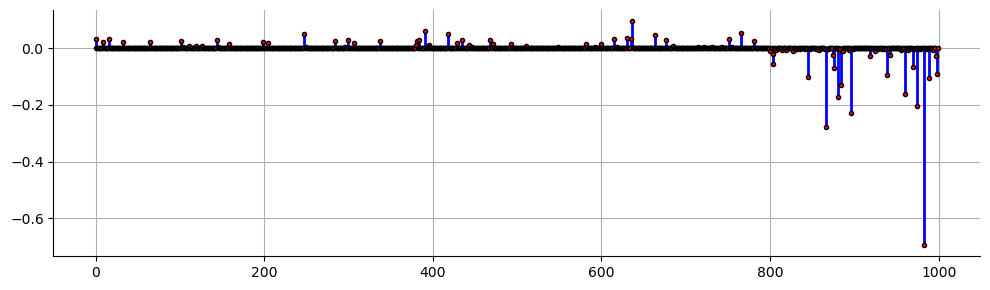

Excitation to inhibition ratio
0.4885553811770917
Excitation strength
5.39450535840897e-05
Inhibition strength
0.003900720631498456


In [107]:
W = net_params["W_rec"]
i = np.argmax(participation)

print("Trial activity")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(trajectories[i, :, :].T, cmap='bwr', vmin = -1, vmax=1) # mean over trials
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Trials")
ax.set_xlabel("Timesteps")
plt.show()

print("Net inputs activity")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(h[i, :, :].T, cmap='bwr', vmin = -1, vmax=1) # mean over trials
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Trials")
ax.set_xlabel("Timesteps")
plt.show()

print("sending")
stem_plot(W_rec[:, i]) # sending
print("receiving")
stem_plot(W_rec[i, :]) # sending

print("Excitation to inhibition ratio")
print(- np.sum(W_rec[i, np.where(dale_mask == 1)[0]]) / np.sum(W_rec[i, np.where(dale_mask == -1)[0]]))

print("Excitation strength")
print(np.mean(W_rec[i, np.where(dale_mask == 1)[0]]**2))

print("Inhibition strength")
print(np.mean(W_rec[i, np.where(dale_mask == -1)[0]]**2))

In [108]:
sorted_indices = np.argsort(participation)

Trial activity


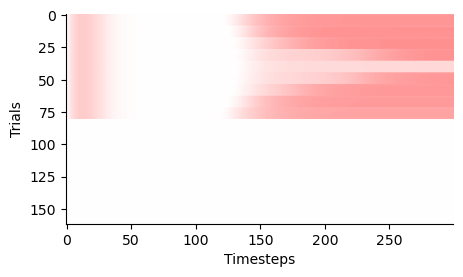

Net inputs activity


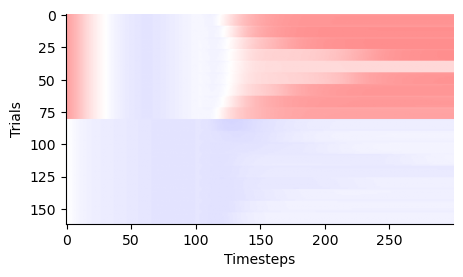

Excitation to inhibition ratio
0.3004099916641271
Excitation strength
2.8922621936594725e-05
Inhibition strength
0.0026965731498586553


In [109]:
i = sorted_indices[-4]

print("Trial activity")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(trajectories[i, :, :].T, cmap='bwr', vmin = -1, vmax=1) # mean over trials
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Trials")
ax.set_xlabel("Timesteps")
plt.show()

print("Net inputs activity")
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(h[i, :, :].T, cmap='bwr', vmin = -1, vmax=1) # mean over trials
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Trials")
ax.set_xlabel("Timesteps")
plt.show()

print("Excitation to inhibition ratio")
print(- np.sum(W_rec[i, np.where(dale_mask == 1)[0]]) / np.sum(W_rec[i, np.where(dale_mask == -1)[0]]))

print("Excitation strength")
print(np.mean(W_rec[i, np.where(dale_mask == 1)[0]]**2))

print("Inhibition strength")
print(np.mean(W_rec[i, np.where(dale_mask == -1)[0]]**2))

In [110]:
# testing net inputs:
W_rec = net_params["W_rec"]
W_inp = net_params["W_inp"]

0.29445861883659125


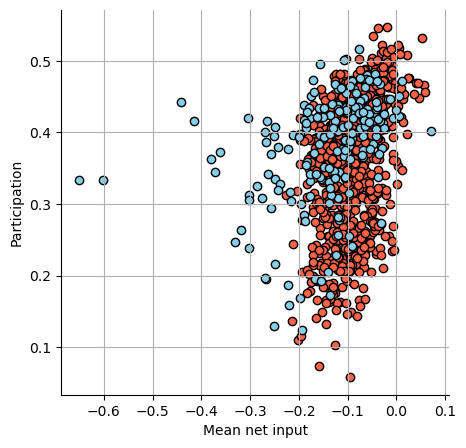

0.12714417932815122


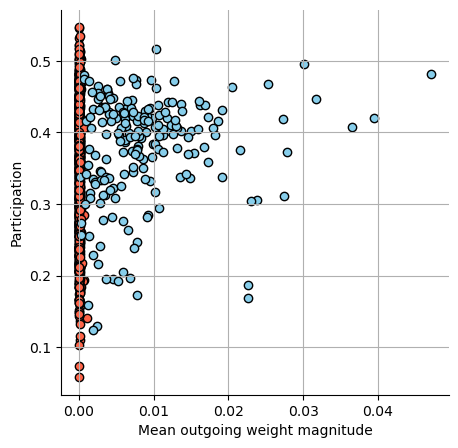

0.08279040435024497


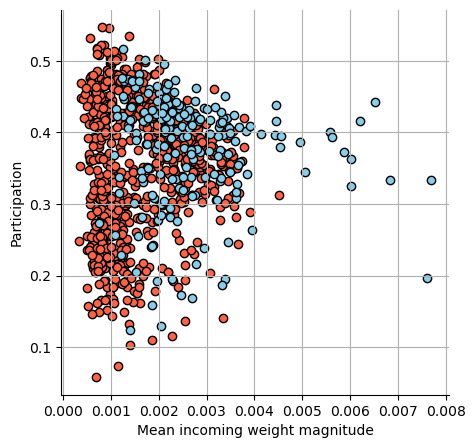

0.08885337620573451


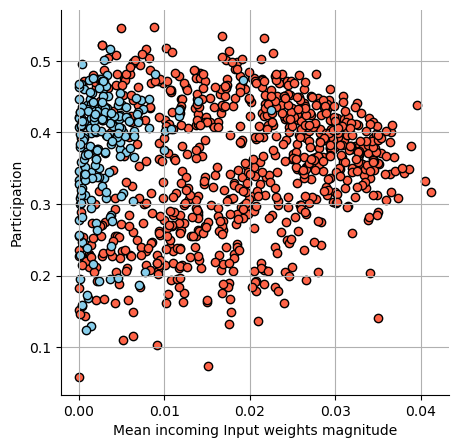

0.17027153398107903


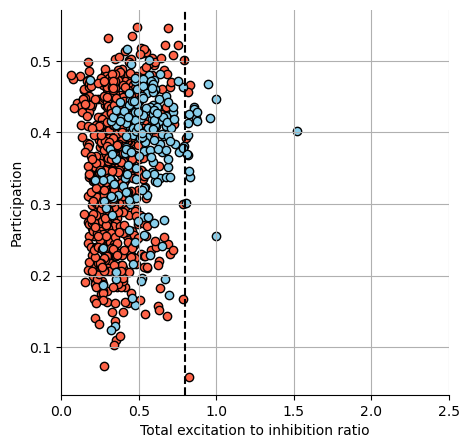

In [111]:
dale_mask = np.sign(np.sum(W, axis = 0))
h_vec = np.mean(h, axis=(1, 2))
print(np.corrcoef(h_vec, participation)[0, 1])
fig, ax = plt.subplots(1,1, figsize=(5,5))
v = h_vec
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_ylabel("Participation")
ax.set_xlabel("Mean net input")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

dale_mask = np.sign(np.sum(W_rec, axis = 0))
print(np.corrcoef(np.mean(np.abs(W_rec)**2, axis=0), participation)[0, 1])
fig, ax = plt.subplots(1,1, figsize=(5,5))
v = np.mean(np.abs(W_rec)**2, axis=0)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel("Mean outgoing weight magnitude")
ax.set_ylabel("Participation")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()


print(np.corrcoef(np.mean(np.abs(W_rec)**2, axis=1), participation)[0, 1])
fig, ax = plt.subplots(1,1, figsize=(5,5))
v = np.mean(np.abs(W_rec)**2, axis=1)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel("Mean incoming weight magnitude")
ax.set
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

print(np.corrcoef(np.mean(np.abs(W_inp)**2, axis=1), participation)[0, 1])
fig, ax = plt.subplots(1,1, figsize=(5,5))
v = np.mean(np.abs(W_inp)**2, axis=1)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel("Mean incoming Input weights magnitude")
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
mplcursors.cursor(hover=True) # Enable hover functionality
plt.show()

dale_mask = np.sign(np.sum(W, axis = 0))
v = -np.sum(W_rec[:, np.where(dale_mask == 1)[0]], axis = 1)/ np.sum(W_rec[:, np.where(dale_mask == -1)[0]], axis = 1)
print(np.corrcoef(v, participation)[0, 1])
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel("Total excitation to inhibition ratio")
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim([0, 2.5])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axvline(0.8, linestyle='--',c='k')
ax.grid(True)
mplcursors.cursor(hover=True)
plt.show()



0.458705900932432


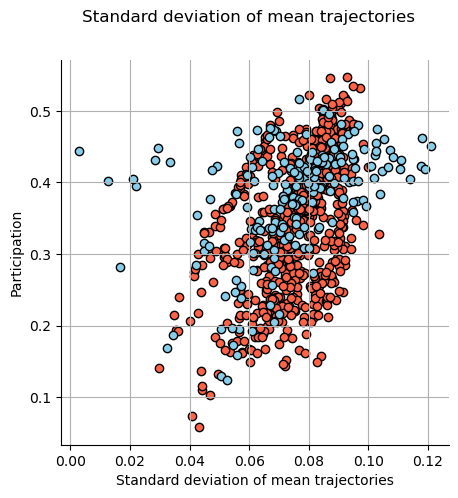

In [112]:

v = np.std(np.mean(trajectories, axis=1), axis = 1) #deviation of mean activity across trials
print(np.corrcoef(v, participation)[0, 1])
title_string = "Standard deviation of mean trajectories"
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.suptitle(title_string)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel(title_string)
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
mplcursors.cursor(hover=True)
plt.show()

The Standard deviation (over trials) of mean of neural response (over time) correlates extremely well with participation, however, it is unusable due to zero gradients when the neuron is inhibited

0.18209979837025753


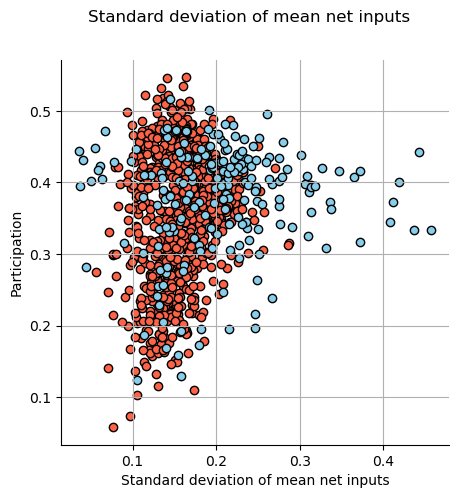

0.16504554855772346


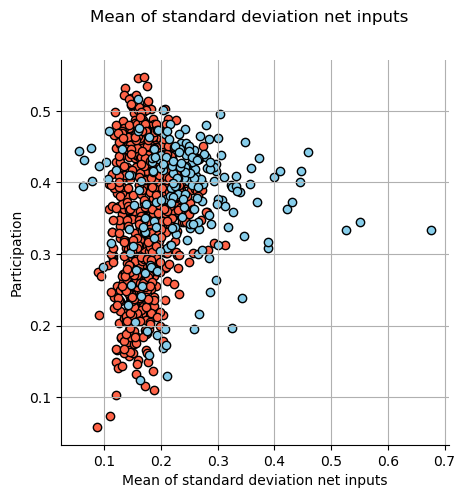

In [113]:
v = np.std(np.mean(h, axis=1), axis = 1) #deviation of mean activity across trials
# v = np.mean(np.std(h, axis=-1), axis = -1) #mean (across time) of deviation across trials
print(np.corrcoef(v, participation)[0, 1])
title_string = "Standard deviation of mean net inputs"
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.suptitle(title_string)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel(title_string)
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
# ax.axvline(np.quantile(v, 0.5), linestyle='--', c='k')
mplcursors.cursor(hover=True)
plt.show()

# v = np.std(np.mean(h, axis=1), axis = 1) #deviation of mean activity across trials
v = np.mean(np.std(h, axis=-1), axis = -1) #mean (across time) of deviation across trials
print(np.corrcoef(v, participation)[0, 1])
title_string = "Mean of standard deviation net inputs"
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.suptitle(title_string)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel(title_string)
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
plt.show()

I think i can penalize low standard deviation of mean net inputs across trial as my next try

0.024571456254583367


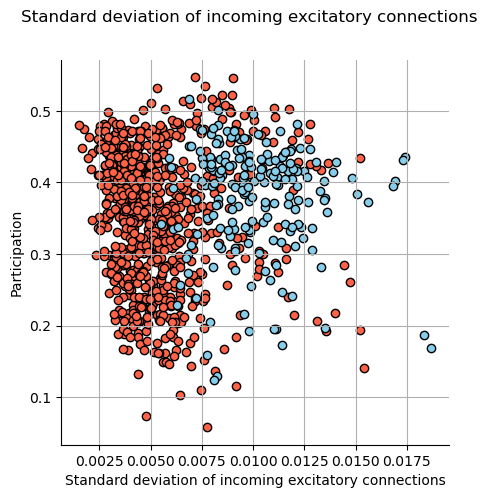

In [114]:
v = np.std(np.abs(W_rec[:, np.where(dale_mask == 1)[0]]), axis=1) #deviation of mean incoming excitatory weights across trials
print(np.corrcoef(v, participation)[0, 1])
title_string = "Standard deviation of incoming excitatory connections"
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.suptitle(title_string)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel(title_string)
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
plt.show()

Also correlates well with participation

0.09995076471641917


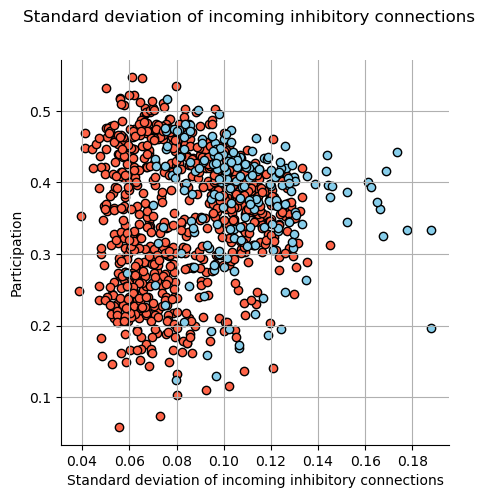

0.024571456254583367


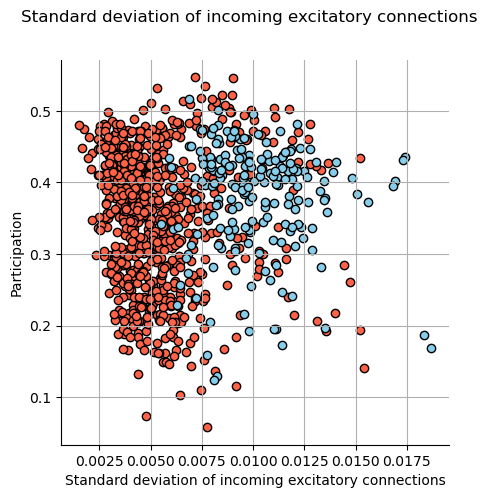

In [115]:
v = np.std(np.abs(W_rec[:, np.where(dale_mask == -1)[0]]), axis=1) #deviation of mean incoming excitatory weights across trials
print(np.corrcoef(v, participation)[0, 1])
title_string = "Standard deviation of incoming inhibitory connections"
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.suptitle(title_string)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel(title_string)
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
plt.show()

v = np.std(np.abs(W_rec[:, np.where(dale_mask == 1)[0]]), axis=1) #deviation of mean incoming excitatory weights across trials
print(np.corrcoef(v, participation)[0, 1])
title_string = "Standard deviation of incoming excitatory connections"
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.suptitle(title_string)
ax.scatter(v[np.where(dale_mask == 1.0)[0]], participation[np.where(dale_mask == 1.0)[0]], edgecolor='k', color = 'tomato')
ax.scatter(v[np.where(dale_mask == -1.0)[0]], participation[np.where(dale_mask == -1.0)[0]], edgecolor='k', color='skyblue')
ax.set_xlabel(title_string)
ax.set_ylabel("Participation")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True)
plt.show()

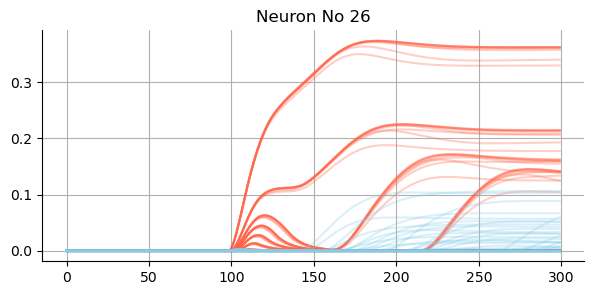

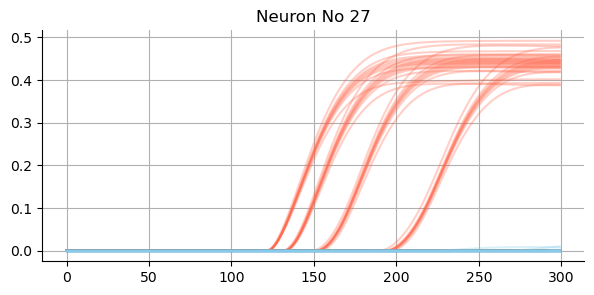

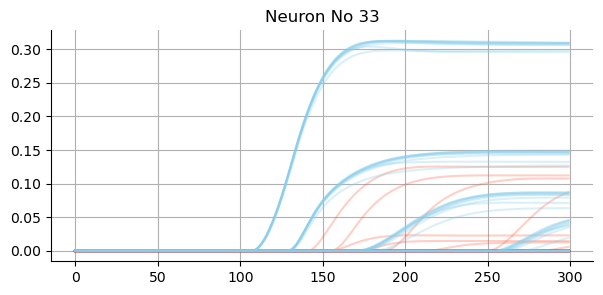

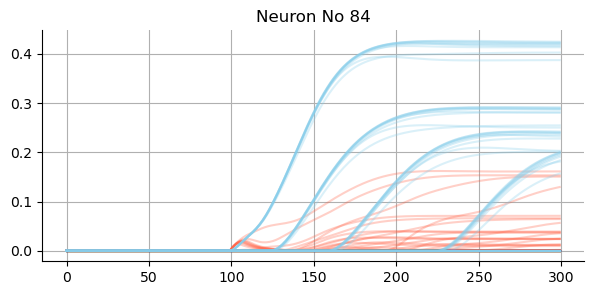

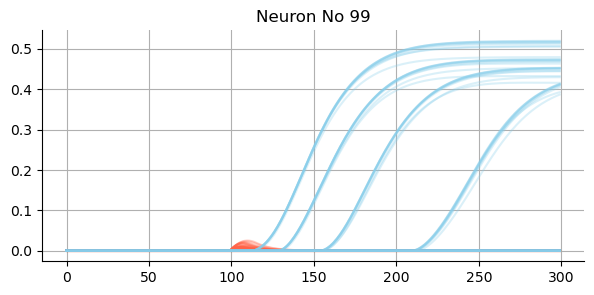

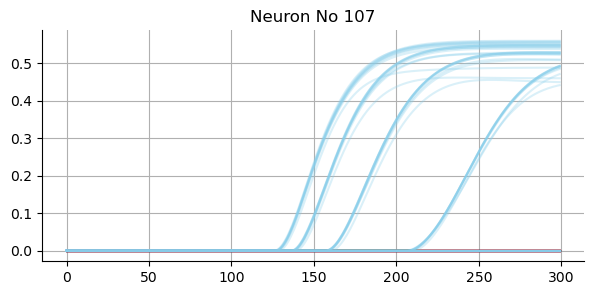

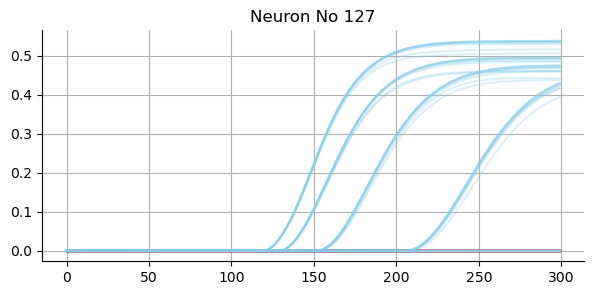

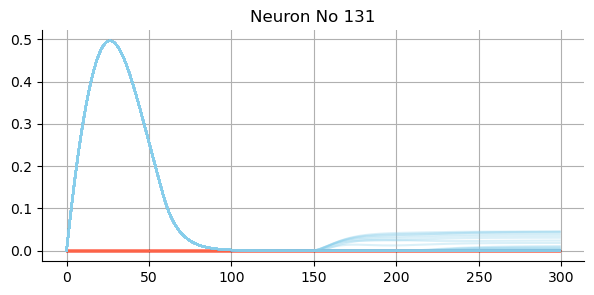

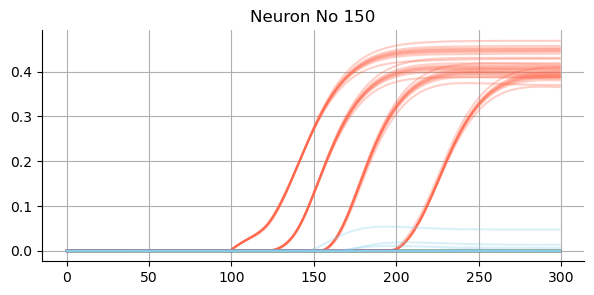

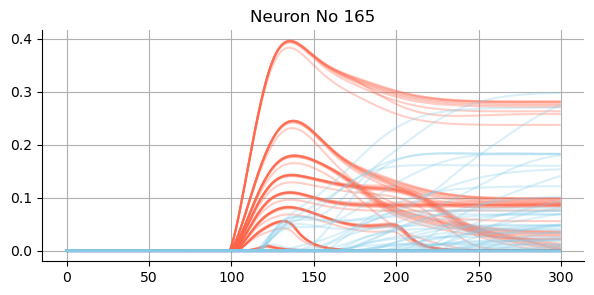

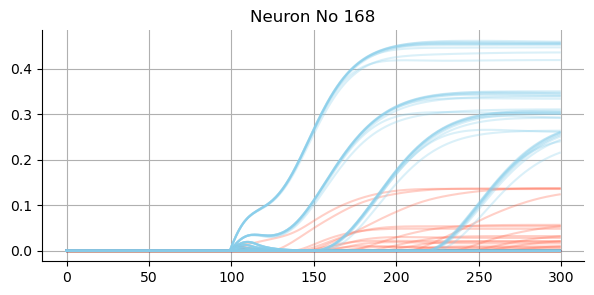

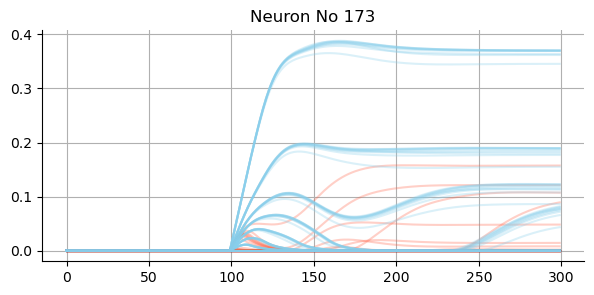

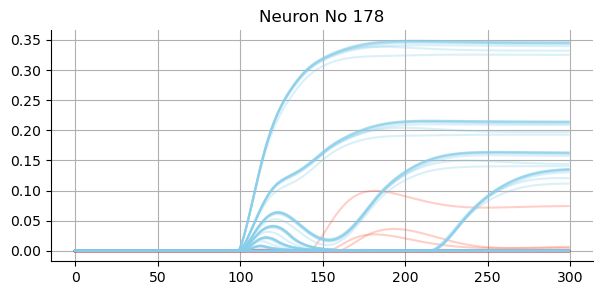

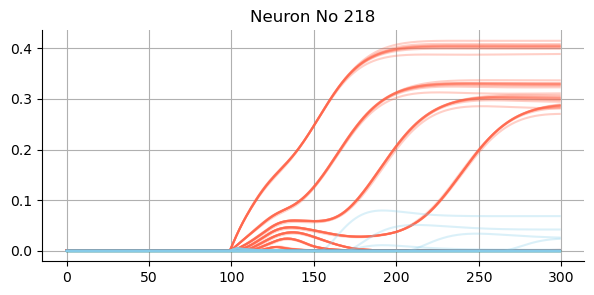

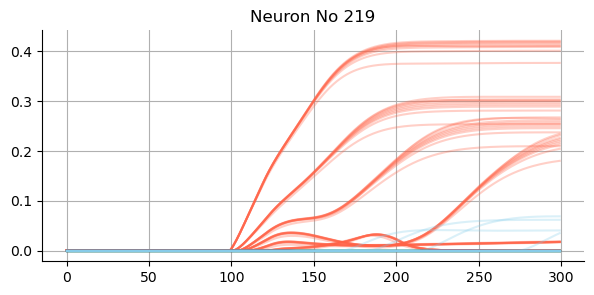

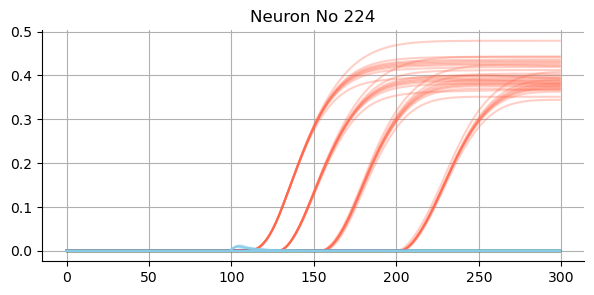

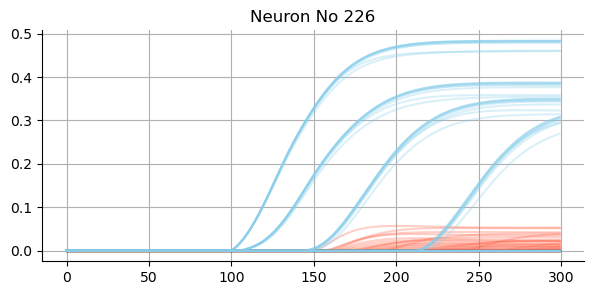

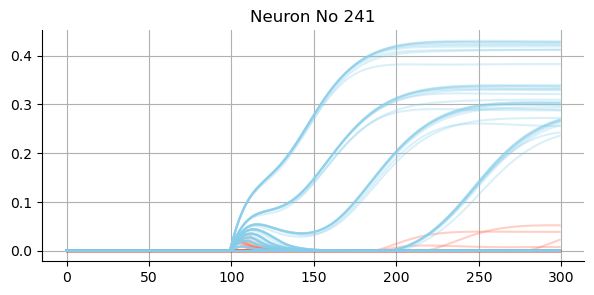

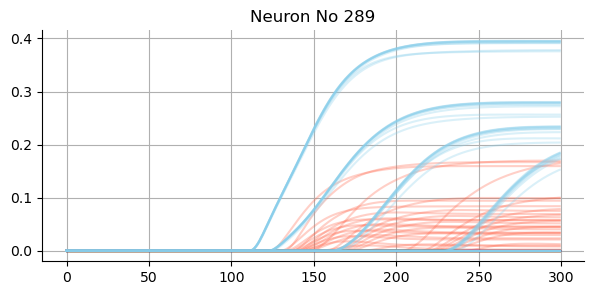

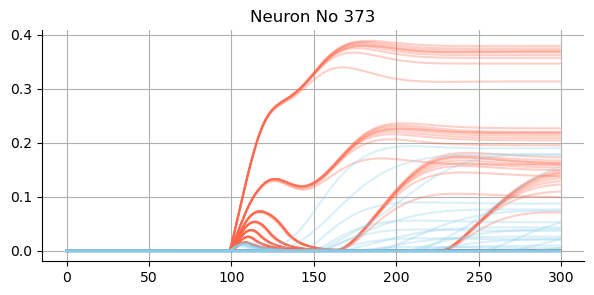

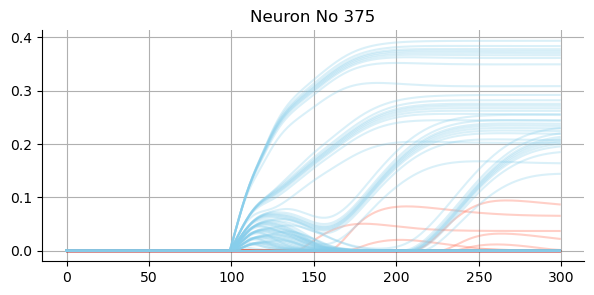

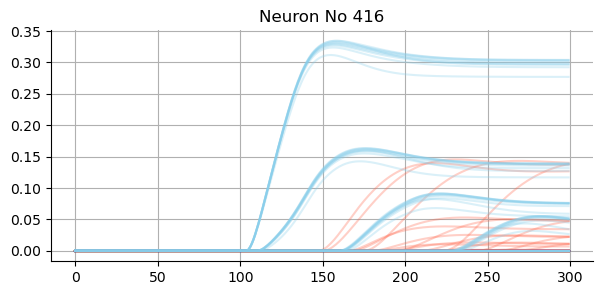

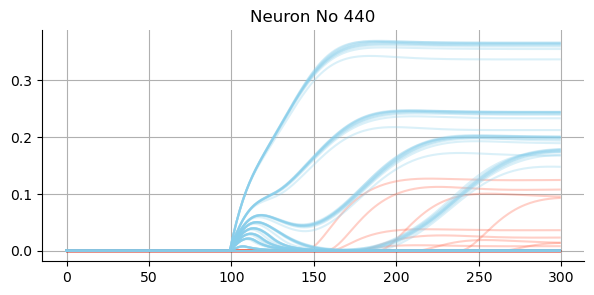

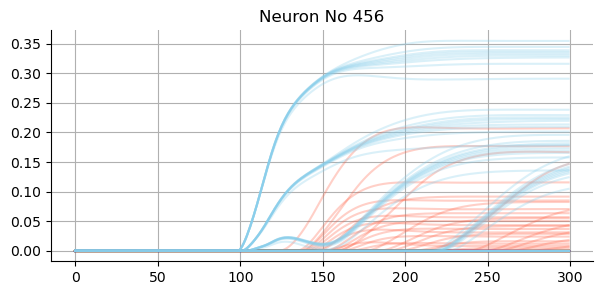

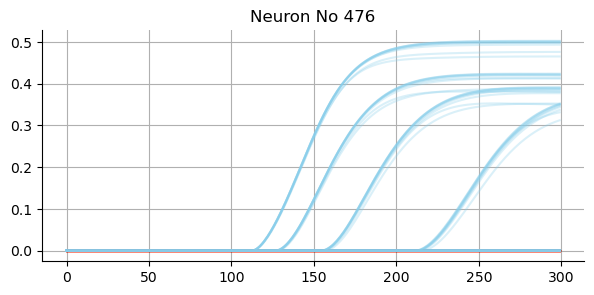

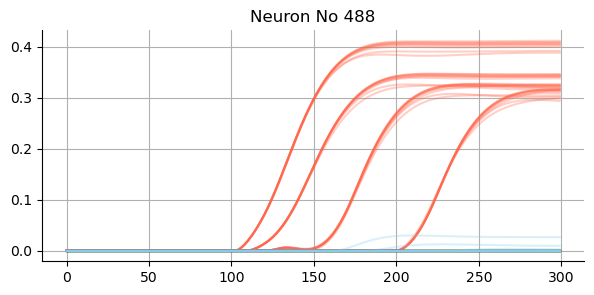

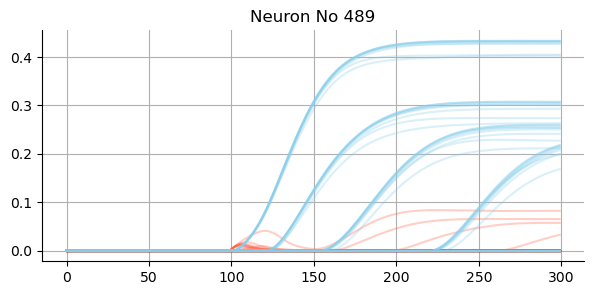

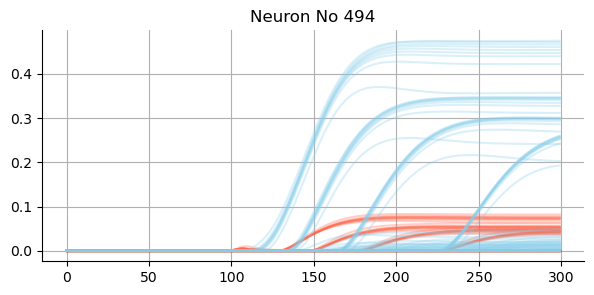

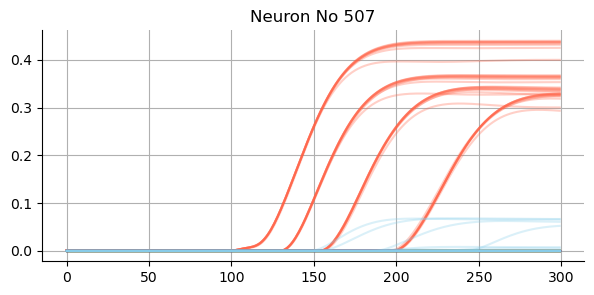

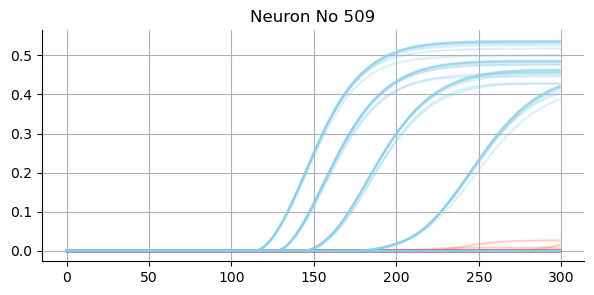

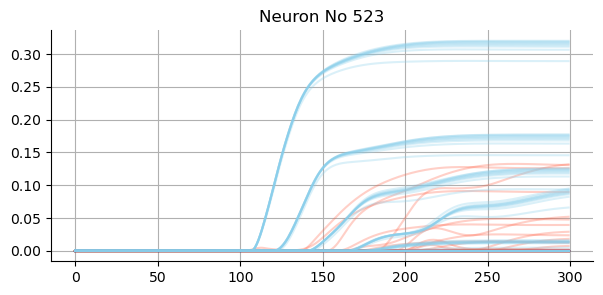

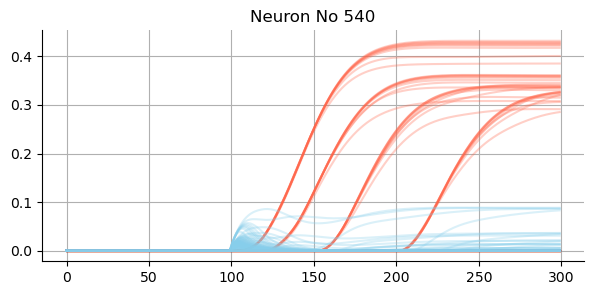

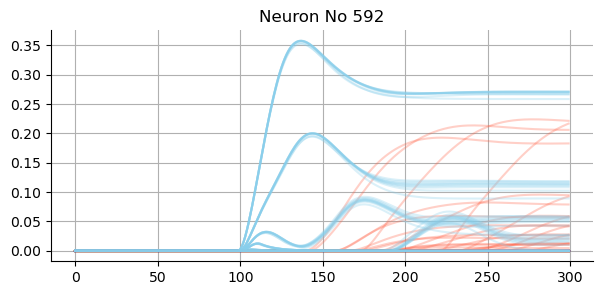

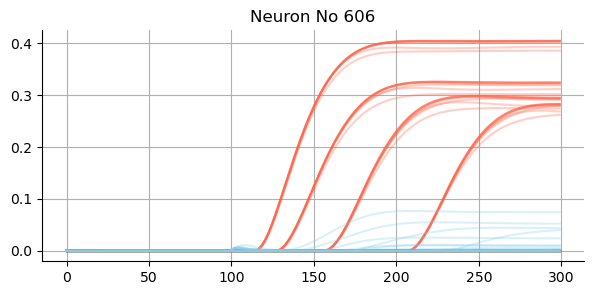

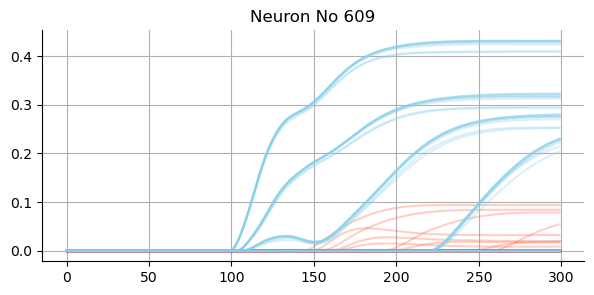

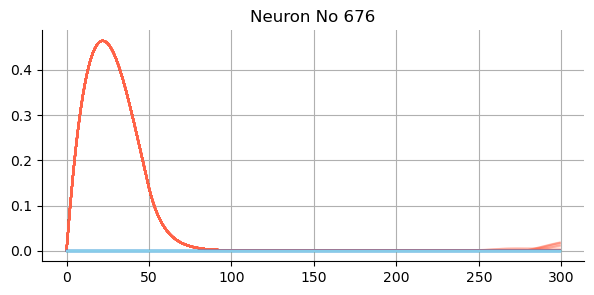

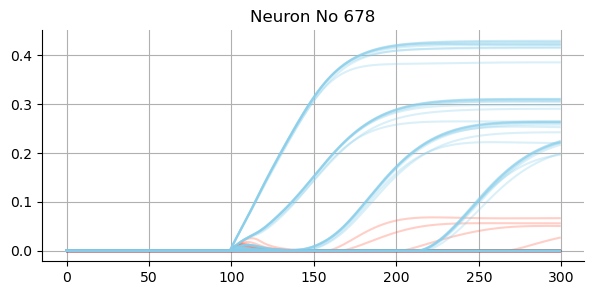

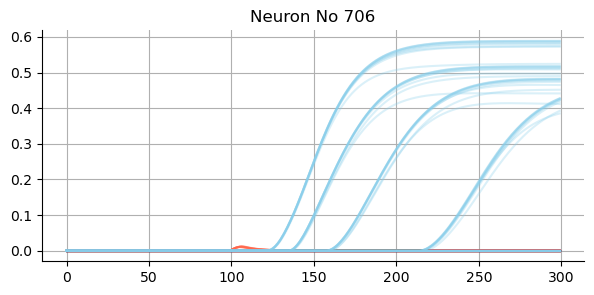

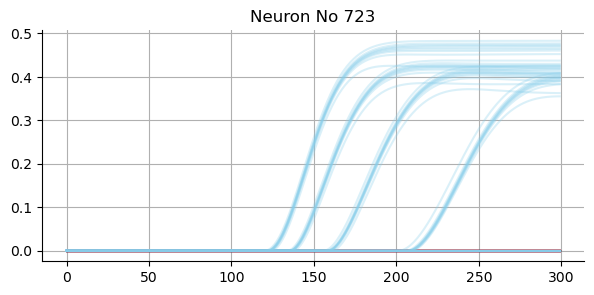

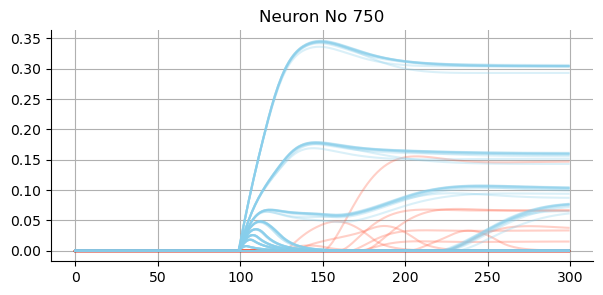

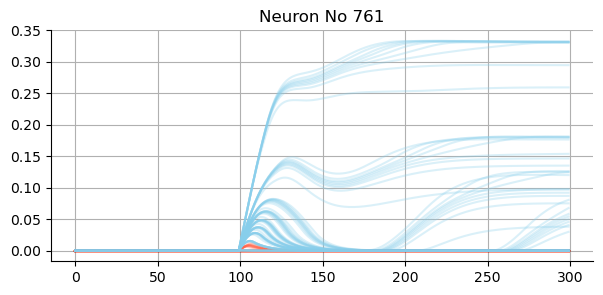

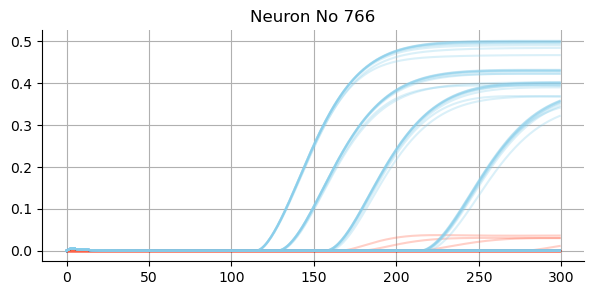

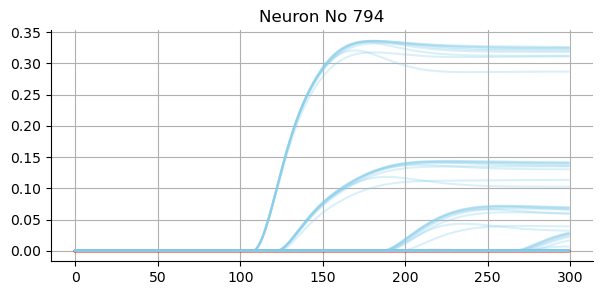

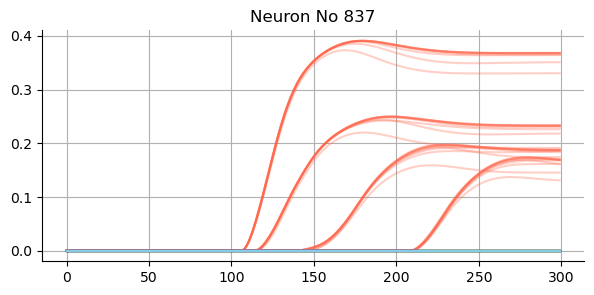

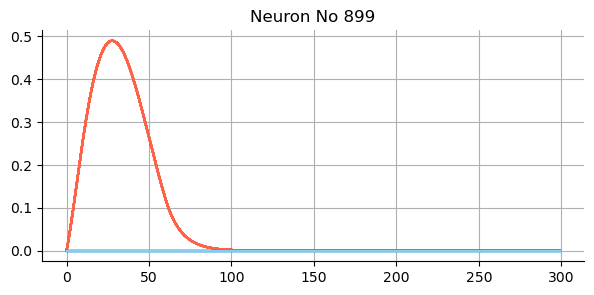

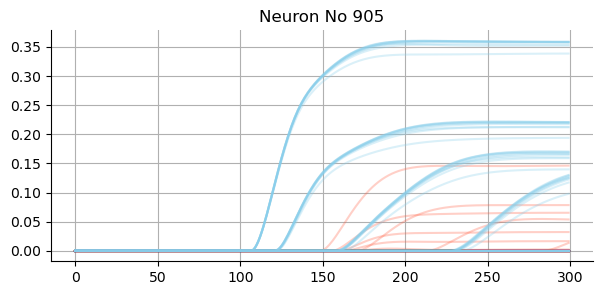

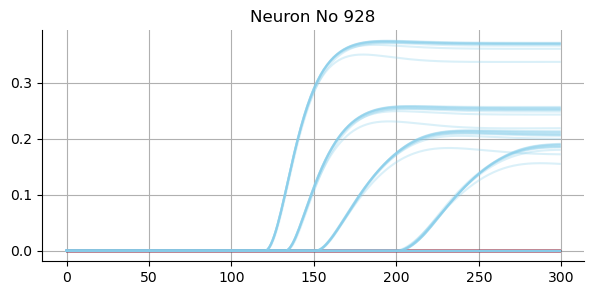

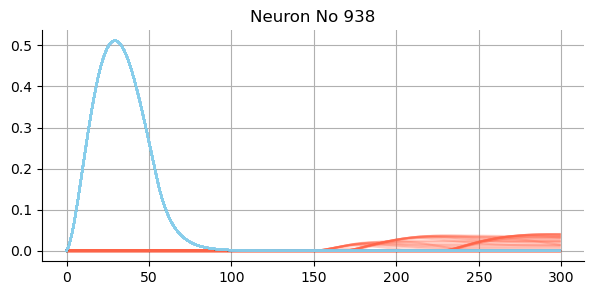

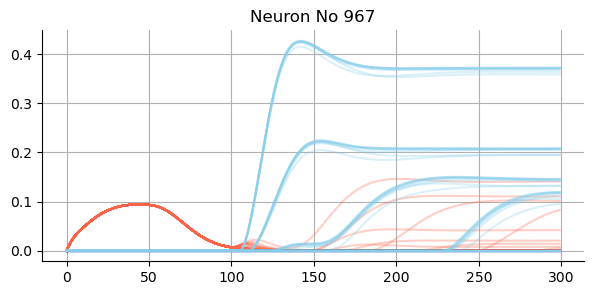

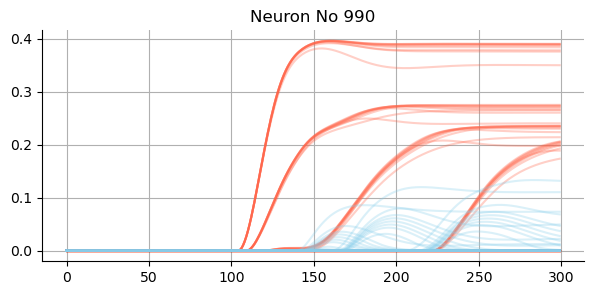

50


In [117]:
cnt = 0
participation = np.std(trajectories, axis=(1, 2)) + np.quantile(trajectories, axis=(1, 2), q=0.9)
thr_low = np.quantile(participation, 0.05)
thr_high = np.quantile(participation, 0.95)
for n in range(trajectories.shape[0])[:]:
    part = np.std(trajectories[n, :, :]) + np.quantile(trajectories[n, :, :], q=0.9)
    # if part > thr_high:
    if part < thr_low:
        fig, ax = plt.subplots(1, 1, figsize = (7, 3))
        for k in range(trajectories.shape[-1]):
            color = 'tomato' if k < trajectories.shape[-1]//2 else 'skyblue'
            ax.plot(trajectories[n, :, k], color = color, alpha = 0.3)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(True)
        ax.set_title(f"Neuron No {n}")
        plt.show()
        cnt += 1
print(cnt)

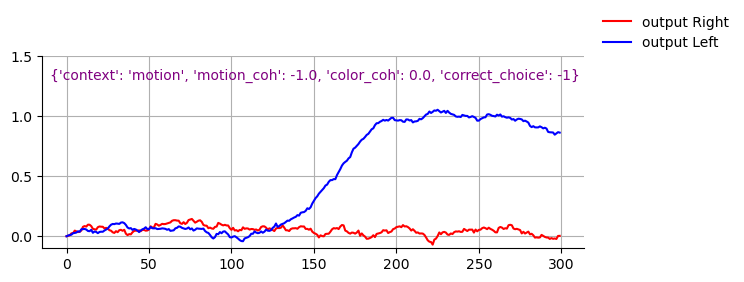

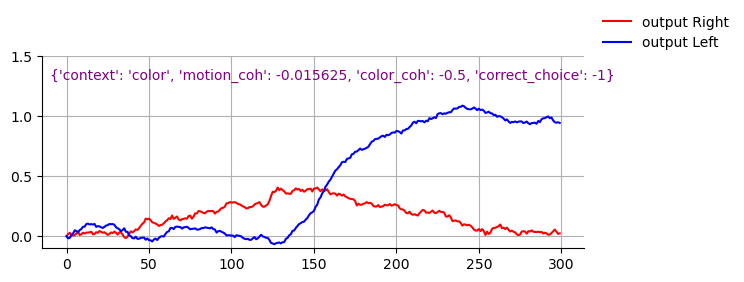

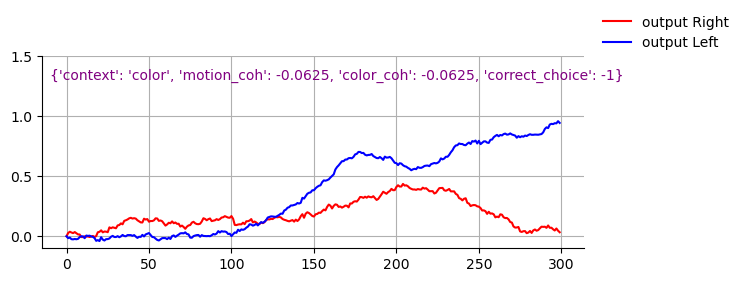

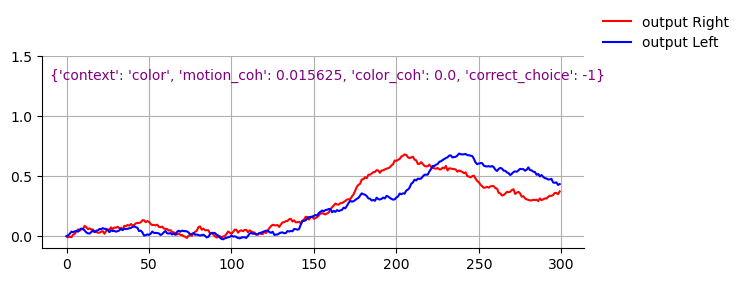

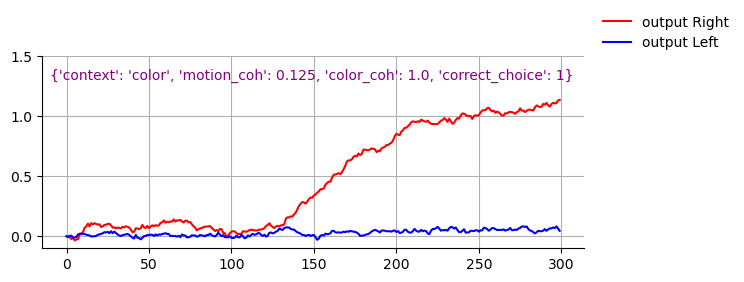

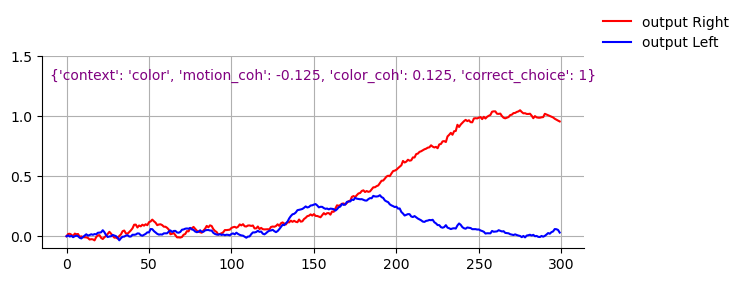

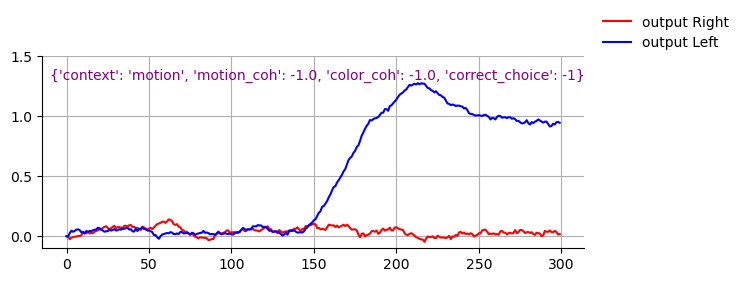

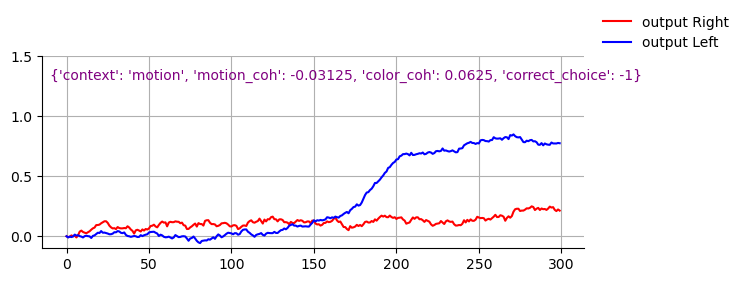

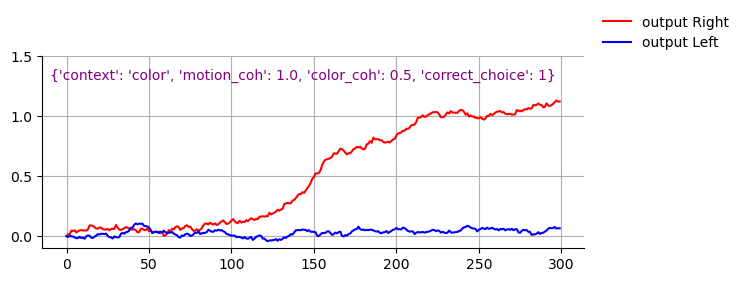

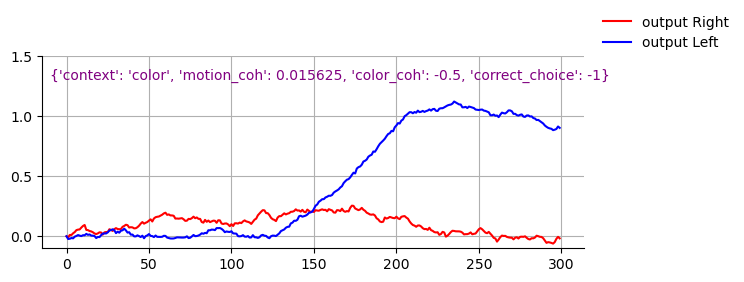

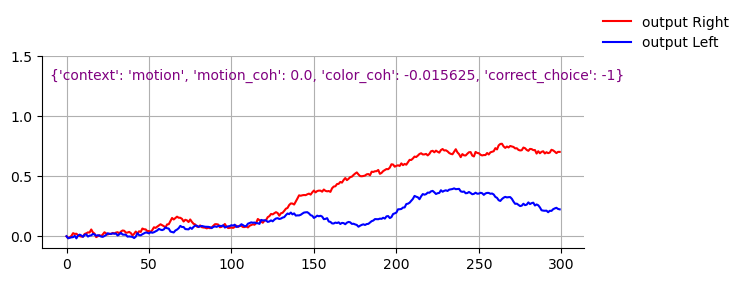

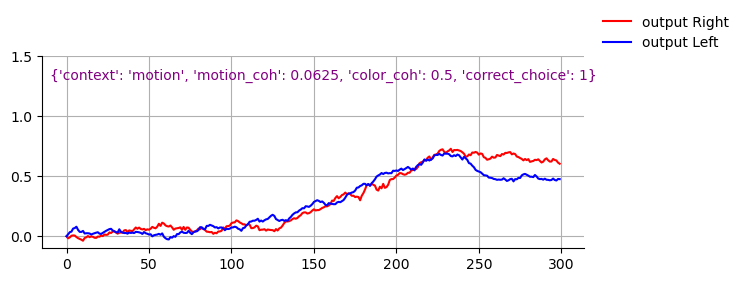

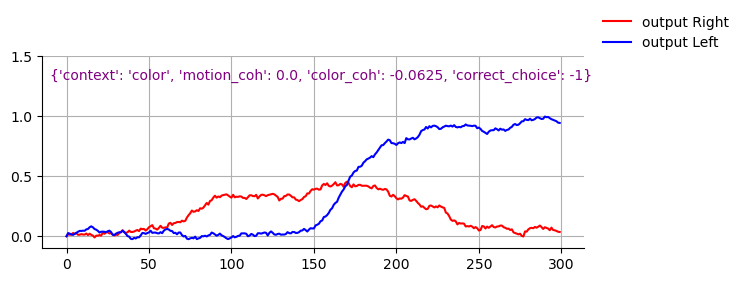

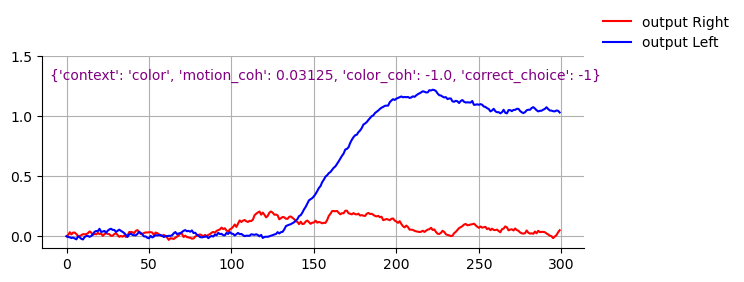

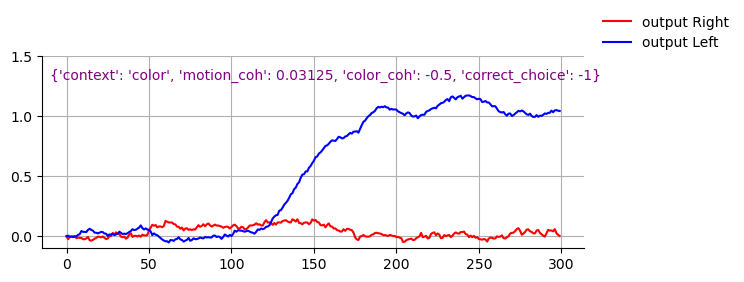

In [38]:
sigma_rec = 0.05
sigma_inp = 0.05
analyzer.RNN.clear_history()
analyzer.RNN.y = analyzer.RNN.y_init
analyzer.RNN.run(input_timeseries=input_batch_valid, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
trajectories = analyzer.RNN.get_history()
outputs = analyzer.RNN.get_output()



for i in range(15):
    k = np.random.randint(outputs.shape[-1])
    fig, ax = plt.subplots(1, 1, figsize=(7, 2.5))
    ax.text(-10, 1.3, conditions_valid[k], color='purple')
    ax.plot(outputs[0, :, k], color='red', label='output Right')
    ax.plot(outputs[1, :, k], color='blue', label='output Left')
    ax.legend(frameon=False, loc = (1.025, 1))
    ax.set_ylim([-0.1, 1.5])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True)
    plt.show()


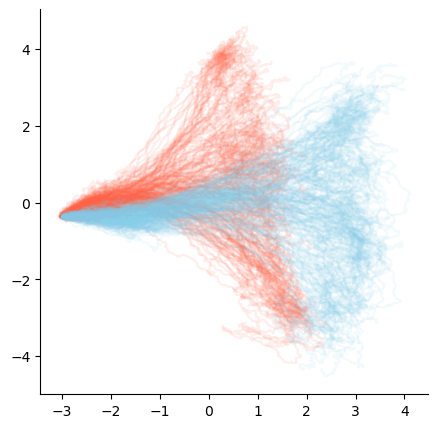

In [39]:
from sklearn.decomposition import PCA
trajectories_flat = trajectories.reshape(trajectories.shape[0], -1)

n_components = 3
pca = PCA(n_components=n_components)
trajectories_pcaed = pca.fit_transform(trajectories_flat.T).T

trajectories_pcaed = trajectories_pcaed.reshape(n_components, trajectories.shape[1], trajectories.shape[2])
K = trajectories_pcaed.shape[-1]

fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(trajectories_pcaed[0, :, :K//2], trajectories_pcaed[2, :, :K//2], color = 'tomato', alpha = 0.1)
ax.plot(trajectories_pcaed[0, :, K//2:], trajectories_pcaed[2, :, K//2:], color = 'skyblue', alpha = 0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [40]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

def _ensure_plotly_renderer(renderer=None):
    if renderer is not None:
        return renderer
    # Try common Jupyter renderers, then fall back to opening a browser tab.
    for r in ["notebook_connected", "jupyterlab", "vscode", "colab", "iframe_connected", "browser"]:
        try:
            pio.renderers.default = r
            return r
        except Exception:
            continue
    return None  # plotly will use its default

def plot_pca_trajectories_plotly(trajectories, center=True, renderer=None):
    """
    trajectories: array-like, shape (N, T, K)
    center: center features before PCA
    renderer: force a specific plotly renderer (e.g., 'notebook_connected', 'browser')
    """
    # trajectories = trajectories / np.max(trajectories, axis=(1, 2), keepdims=True)
    arr = np.asarray(trajectories, dtype=float)
    
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D array (N,T,K); got shape {arr.shape}")
    N, T, K = arr.shape
    if N == 0 or T == 0 or K == 0:
        raise ValueError(f"Empty dimension in (N,T,K)={arr.shape}")
    
    # Build samples as rows: (T*K, N)
    X = arr.reshape(N, T*K).T  # (samples, features)
    if center:
        X = X - X.mean(axis=0, keepdims=True)

    # PCA via SVD
    U, S, Vt = np.linalg.svd(X, full_matrices=False)  # Vt: (min(T*K, N), N)
    n_comp = int(min(3, Vt.shape[0]))
    if n_comp < 1:
        raise ValueError("Data has rank 0 after centering — cannot compute PCA.")
    comps = Vt[:n_comp, :]  # (n_comp, N)

    # Project: result (n_comp, T, K) -> (T, K, n_comp)
    proj = np.tensordot(comps, arr, axes=(1, 0))
    proj = np.moveaxis(proj, 0, -1)  # (T, K, n_comp)

    # Prepare figure
    fig = go.Figure()
    split = K // 2
    for k in range(K):
        color = "tomato" if k < split else "skyblue"
        traj = proj[:, k, :]  # (T, n_comp)
        # If fewer than 3 PCs, pad with zeros so Scatter3d is happy.
        if n_comp == 1:
            x, y, z = traj[:, 0], np.zeros(T), np.zeros(T)
        elif n_comp == 2:
            x, y, z = traj[:, 0], traj[:, 1], np.zeros(T)
        else:
            x, y, z = traj[:, 0], traj[:, 1], traj[:, 2]

        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode="lines",
            line=dict(color=color, width=3),
            name=f"Trial {k}",
            showlegend=False  # avoid huge legends
        ))

    # Add compact legend proxies
    fig.add_trace(go.Scatter3d(x=[None], y=[None], z=[None],
                               mode="lines", line=dict(color="tomato", width=3),
                               name="k < K//2"))
    fig.add_trace(go.Scatter3d(x=[None], y=[None], z=[None],
                               mode="lines", line=dict(color="skyblue", width=3),
                               name="k ≥ K//2"))

    titles = ["PC1", "PC2", "PC3"][:n_comp] + [""]*(3-n_comp)
    fig.update_layout(
        scene=dict(xaxis_title=titles[0] or "PC1",
                   yaxis_title=titles[1] or "PC2",
                   zaxis_title=titles[2] or "PC3"),
        margin=dict(l=0, r=0, t=30, b=0),
        title="3D PCA of Trajectories (N→3)"
    )

    used_renderer = _ensure_plotly_renderer(renderer)
    fig.show(renderer=used_renderer)
    return fig

# Example usage:
fig = plot_pca_trajectories_plotly(trajectories, renderer="browser")  # trajectories shape (N, T, K)
# If nothing shows, force a renderer: fig = plot_pca_trajectories_plotly(trajectories, renderer="browser")


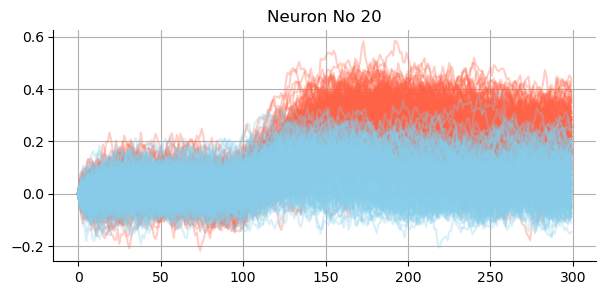

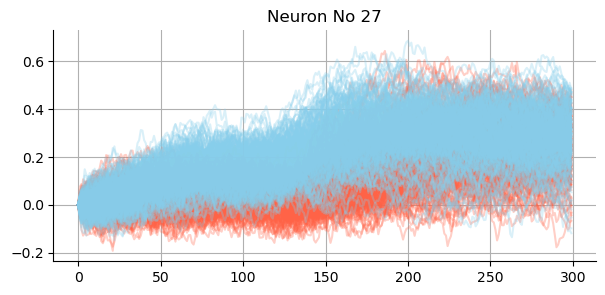

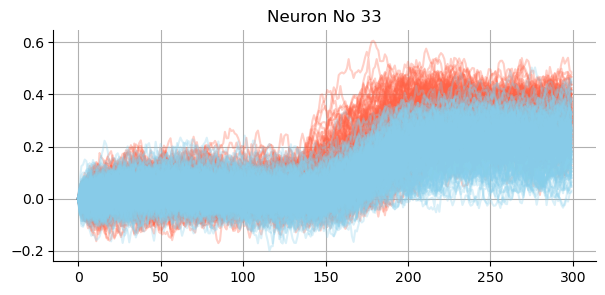

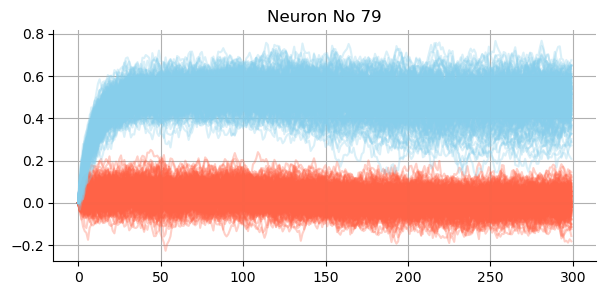

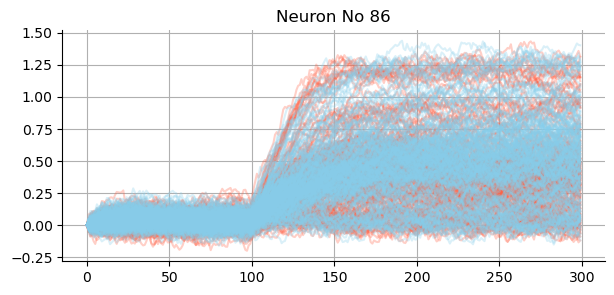

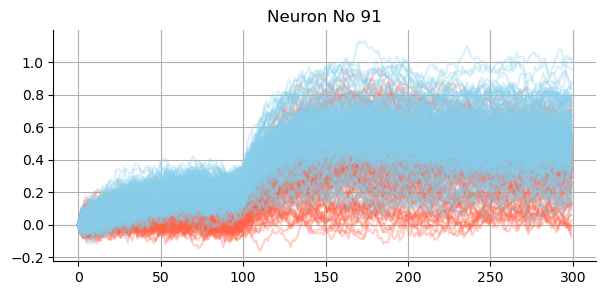

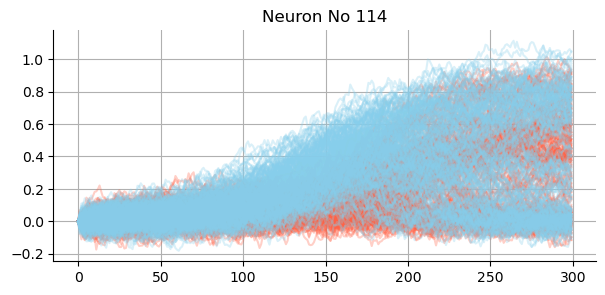

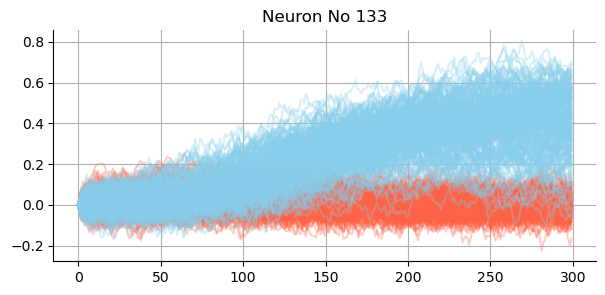

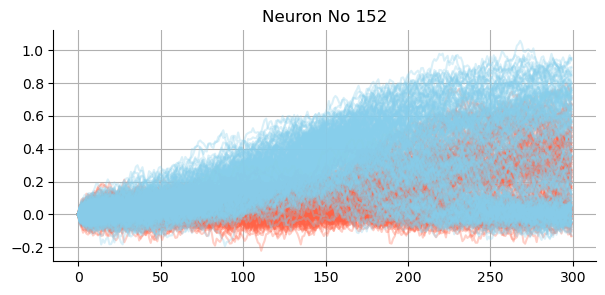

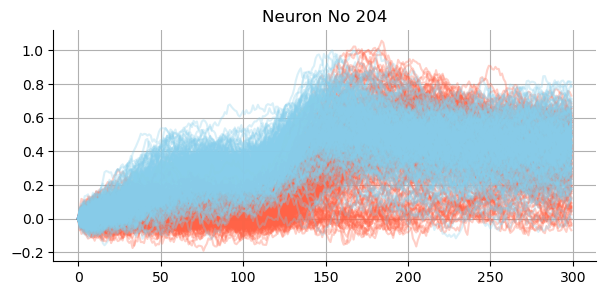

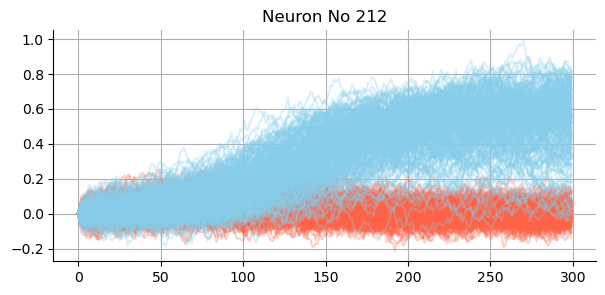

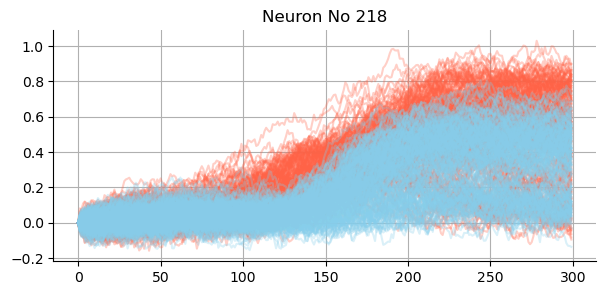

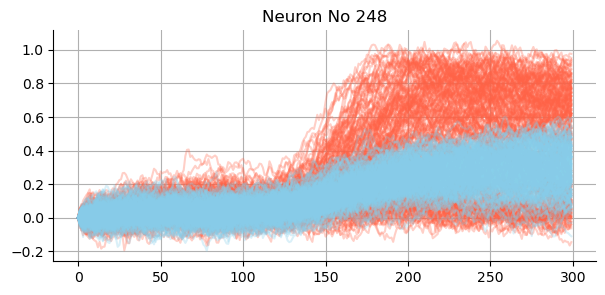

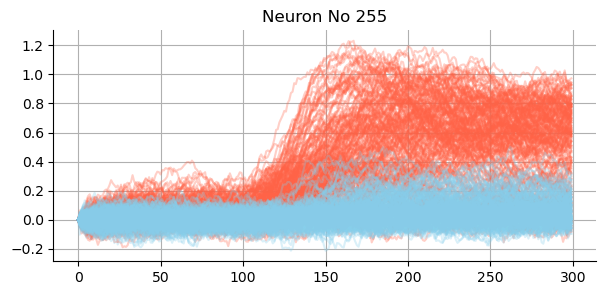

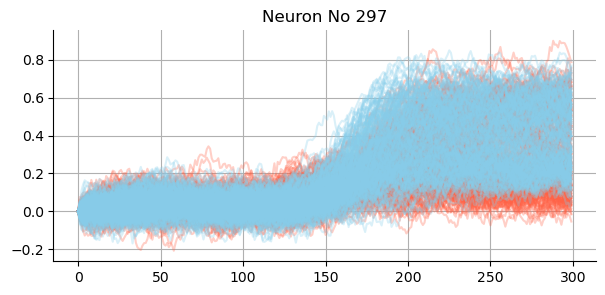

15


In [41]:
cnt = 0
net_input_mean = np.mean(h, axis = (1, 2))
thr = np.quantile(net_input_mean, 0.95)
for n in range(trajectories.shape[0])[:]:
    part = np.std(trajectories[n, :, :]) + np.mean(trajectories[n, :, :])
    if net_input_mean[n] > thr:
        
        fig, ax = plt.subplots(1, 1, figsize = (7, 3))
        for k in range(trajectories.shape[-1]):
            color = 'tomato' if k < trajectories.shape[-1]//2 else 'skyblue'
            ax.plot(trajectories[n, :, k], color = color, alpha = 0.3)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(True)
        ax.set_title(f"Neuron No {n}")
        plt.show()
        cnt += 1
print(cnt)

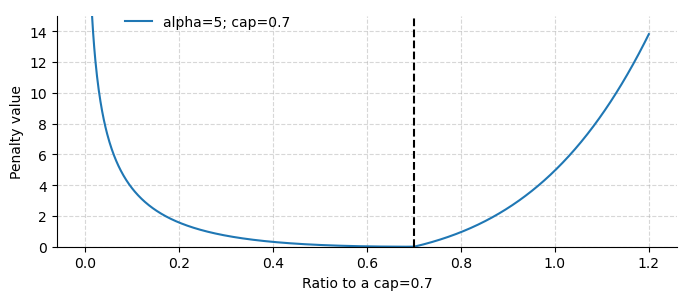

In [42]:
def s_magnitude_penalty(self, states, input, cap_low=0.05, cap_high=0.7, q=0.9, alpha=5.0, beta=1.0, eps=1e-12):
    x = states.abs().view(states.size(0), -1)
    dev, dt = states.device, states.dtype
    sN = torch.log1p(torch.as_tensor(self.UpV, device=dev, dtype=dt)) / \
         torch.log1p(torch.as_tensor(self.RNN.N, device=dev, dtype=dt))  # ~ O(1/log N)
    clo = torch.as_tensor(cap_low, device=dev, dtype=dt) * sN
    chi = torch.as_tensor(cap_high, device=dev, dtype=dt) * sN
    eps = torch.as_tensor(eps, device=dev, dtype=dt)

    s_q = torch.quantile(x + eps, q, dim=1)  # per-neuron summary
    e_lo = torch.log((s_q + eps) / (clo + eps))  # <0 if below lower cap
    e_hi = torch.log((s_q + eps) / (chi + eps))  # >0 if above upper cap

    under = torch.pow(torch.relu(-e_lo), 2)  # quadratic push from zero
    over = torch.expm1(alpha * torch.relu(e_hi))  # steep over-cap
    return (under + beta * over).mean()


def penalty(x, cap_low=0.1, cap_high=0.9, alpha=5, eps=1e-12):
    e_lo = np.log((x + eps) / (cap_low + eps))  # <0 if below lower cap
    e_hi = np.log((x + eps) / (cap_high + eps))  # >0 if above upper cap
    under = np.pow(np.maximum(-e_lo, 0), 2)  # quadratic push from zero
    over = np.exp(alpha * np.maximum(e_hi, 0)) - 1.0  # steep over-cap
    return (under + over)

x = np.linspace(0, 1.2, 1001)
x[0] = 1e-12
cap = 0.7
a = 5
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(x, penalty(x, cap_low=cap,cap_high = cap, alpha=a), label=f"alpha={a}; cap={cap}")
ax.axvline(cap, linestyle='--', color='k')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, linestyle='--', alpha = 0.5)
ax.set_xlabel(f"Ratio to a cap={cap}")
ax.set_ylabel(f"Penalty value")
ax.set_ylim([0, 15])
ax.legend(loc=(0.1, 0.92), frameon=False)
plt.savefig("penalty.svg", bbox_inches='tight', dpi=300) 
plt.show()
    